In [ ]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch
import sys, os
sys.path.append(os.pardir)
sys.path.append(
    os.path.join(os.getcwd(), 'deep-learning-from-scratch')
)

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 573 (delta 3), reused 0 (delta 0), pack-reused 562 (from 4)
Receiving objects: 100% (573/573), 10.61 MiB | 12.51 MiB/s, done.
Resolving deltas: 100% (290/290), done.


 합성곱 풀링 구현

In [ ]:
import numpy as np

In [ ]:
x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [ ]:
x[0].shape

(1, 28, 28)

im2col구현

In [ ]:
import numpy as np

# 입력 데이터와 필터 정의
x = np.array(
[#배치1
    [#블록1
        [#채널1
            [1, 2, 3, 4],
            [5, 6, 7, 9],
            [10, 11, 12, 13],
            [14, 15, 16, 17],
        ],
        [#채널2
            [18, 19, 20, 21],
            [22, 23, 24, 25],
            [26, 27, 28, 29],
            [30, 31, 32, 33],
        ],
        [#채널3
            [34, 35, 36, 37],
            [38, 39, 40, 41],
            [42, 43, 44, 45],
            [46, 47, 48, 49],
        ]
    ],
    [#블록2
        [#채널1
            [1, 2, 3, 4],
            [5, 6, 7, 9],
            [10, 11, 12, 13],
            [14, 15, 16, 17],
        ],
        [#채널2
            [18, 19, 20, 21],
            [22, 23, 24, 25],
            [26, 27, 28, 29],
            [30, 31, 32, 33],
        ],
        [#채널3
            [34, 35, 36, 37],
            [38, 39, 40, 41],
            [42, 43, 44, 45],
            [46, 47, 48, 49],
        ]
    ]
])

f = np.array(
[#필터배치
    [#필터블록1
        [#필터채널1
            [1, 2],
            [3, 4]
        ],
        [#필터채널2
            [5, 6],
            [7, 8]
        ],
        [#필터채널3
            [9, 10],
            [11, 12]
        ]
    ],
    [#필터블록2
        [#필터채널1
            [12, 11],
            [10, 9]
        ],
        [#필터채널2
            [8, 7],
            [6, 7]
        ],
        [#필터채널3
            [4, 3],
            [2, 1]
        ]
    ]
])

print(x)
print('---' * 10)
print(f)

N,   C,  H,  W = x.shape
FN, FC, FH, FW = f.shape

S = 1
P = 0

print(f"N: {N}, C: {C}, H: {H}, W: {W}")
print(f"FN: {FN}, FC: {FC}, FH: {FH}, FW: {FW}")
print(f"S: {S}, P: {P}")


def im2col(x, FH, FW, stride=1, padding=0):
    N, C, H, W = x.shape

    OH = ( ( H + 2 * padding - FH ) // stride ) + 1
    OW = ( ( W + 2 * padding - FW ) // stride ) + 1

    #원본 손상 방지하고
    #카피
    img = x.copy()
    col = np.zeros((N * OH * OW, C * FH * FW))

    current_col = 0  # col 배열의 현재 행 위치를 추적

    # 세로 방향 순회
    # 0부터 출력 끝까지 순회하는데.
    for y in range(OH):
        y_start = y * stride
        y_max = y_start + FH  # 현재 필터의 세로 끝 위치

        # 가로 방향 순회
        for x in range(OW):
            x_start = x * stride
            x_max = x_start + FW  # 현재 필터의 가로 끝 위치

            # 현재 위치에서 필터 크기만큼의 영역 추출
            #N, C, H, W 순서
            #모든 N, 모든 C에 대해서
            #y:y_max까지 x:x_max까지 잘라내서
            #하나의 윈도우로 만든다.
            current_window = img[:, :, y:y_max,  x:x_max]
            # (N, C, FH, FW) -> (N, C * FH * FW)
            # 채널 3
            # 필터 높이 2
            # 필터 넓이 2
            # 계산결과 12 = 3 * 2 * 2
            #배치 사이즈 크기로 모양을 만든다.
            window_reshaped = current_window.reshape(N, -1)
            #print(f"current_window: {current_window}")
            #print(f"window_reshaped: {window_reshaped}")

            # col 배열에 저장
            # N개 배치에 대해서
            for batch in range(N):
                #윈도우를 배치별 채널별로 위치에 넣는다.
                #print(f"location : { current_col + batch * (OH * OW)}, current_col: {current_col}, batch : { batch}, OW : {OW} , OH : {OH} ")
                #current_col : 현재 나의 라인.
                #(OH * OW) : 슬라이딩 윈도우의 크기
                # batch : 채널 점핑용.
                line = current_col + batch * (OH * OW)
                col[line] = window_reshaped[batch]
            # 다음 위치를 위하여 위치를 변경.
            current_col += 1

    return col

OH = ( ( H + 2 * P - FH ) // S ) + 1
OW = ( ( W + 2 * P - FW ) // S ) + 1

# im2col 변환
x_col = im2col(x, FH, FW, S, P)
print("im2col 방식 결과:\n", x_col)

XCH, XCW = x_col.shape
print(f"XCH: {XCH}, XCW: {XCW}")

# 필터 재구성
f_col = f.reshape(FN, -1).T  # shape: (C*FH*FW, FN)

print("필터 재구성 결과:\n", f_col)

# 행렬곱 수행
out = x_col.dot(f_col)

print(f"out : {out}")



#result = out.reshape(N,FN,OH,OW)
#위 처럼 되야하나  구조 보존을 위하여 (N, OH, OW, FN)으로 변환한다.
result = out.reshape(N, OH, OW, FN)

print(f"result(transpose After): {result}")

#위 처럼 변형된 차원의 위치를 변경한다.
#result = result.transpose(0, 3, 1, 2)
result = result.transpose(0, 3, 2, 1)

print("im2col 방식 합성곱 결과:\n", result)

# 직접 방식 합성곱 계산
output = np.zeros((f.shape[0], OH, OW))

[[[[ 1  2  3  4]
   [ 5  6  7  9]
   [10 11 12 13]
   [14 15 16 17]]

  [[18 19 20 21]
   [22 23 24 25]
   [26 27 28 29]
   [30 31 32 33]]

  [[34 35 36 37]
   [38 39 40 41]
   [42 43 44 45]
   [46 47 48 49]]]


 [[[ 1  2  3  4]
   [ 5  6  7  9]
   [10 11 12 13]
   [14 15 16 17]]

  [[18 19 20 21]
   [22 23 24 25]
   [26 27 28 29]
   [30 31 32 33]]

  [[34 35 36 37]
   [38 39 40 41]
   [42 43 44 45]
   [46 47 48 49]]]]
------------------------------
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]

  [[ 9 10]
   [11 12]]]


 [[[12 11]
   [10  9]]

  [[ 8  7]
   [ 6  7]]

  [[ 4  3]
   [ 2  1]]]]
N: 2, C: 3, H: 4, W: 4
FN: 2, FC: 3, FH: 2, FW: 2
S: 1, P: 0
im2col 방식 결과:
 [[ 1.  2.  5.  6. 18. 19. 22. 23. 34. 35. 38. 39.]
 [ 2.  3.  6.  7. 19. 20. 23. 24. 35. 36. 39. 40.]
 [ 3.  4.  7.  9. 20. 21. 24. 25. 36. 37. 40. 41.]
 [ 5.  6. 10. 11. 22. 23. 26. 27. 38. 39. 42. 43.]
 [ 6.  7. 11. 12. 23. 24. 27. 28. 39. 40. 43. 44.]
 [ 7.  9. 12. 13. 24. 25. 28. 29. 40. 41. 44. 45.]
 [10. 11. 14. 15.

In [ ]:
from common.util import im2col
# 입력 데이터와 필터 정의
x = np.array(
[#배치1
    [#블록1
        [#채널1
            [1, 2, 3, 4],
            [5, 6, 7, 9],
            [10, 11, 12, 13],
            [14, 15, 16, 17],
        ],
        [#채널2
            [18, 19, 20, 21],
            [22, 23, 24, 25],
            [26, 27, 28, 29],
            [30, 31, 32, 33],
        ],
        [#채널3
            [34, 35, 36, 37],
            [38, 39, 40, 41],
            [42, 43, 44, 45],
            [46, 47, 48, 49],
        ]
    ],
    [#블록2
        [#채널1
            [1, 2, 3, 4],
            [5, 6, 7, 9],
            [10, 11, 12, 13],
            [14, 15, 16, 17],
        ],
        [#채널2
            [18, 19, 20, 21],
            [22, 23, 24, 25],
            [26, 27, 28, 29],
            [30, 31, 32, 33],
        ],
        [#채널3
            [34, 35, 36, 37],
            [38, 39, 40, 41],
            [42, 43, 44, 45],
            [46, 47, 48, 49],
        ]
    ]
])

f = np.array(
[#필터배치
    [#필터블록1
        [#필터채널1
            [1, 2],
            [3, 4]
        ],
        [#필터채널2
            [5, 6],
            [7, 8]
        ],
        [#필터채널3
            [9, 10],
            [11, 12]
        ]
    ],
    [#필터블록2
        [#필터채널1
            [12, 11],
            [10, 9]
        ],
        [#필터채널2
            [8, 7],
            [6, 7]
        ],
        [#필터채널3
            [4, 3],
            [2, 1]
        ]
    ]
])

print(x)
print('---' * 10)
print(f)

N,   C,  H,  W = x.shape
FN, FC, FH, FW = f.shape

x_col = im2col(x, FH, FW, S, P)
print("im2col 책의 구현 방식 결과:\n", x_col)

[[[[ 1  2  3  4]
   [ 5  6  7  9]
   [10 11 12 13]
   [14 15 16 17]]

  [[18 19 20 21]
   [22 23 24 25]
   [26 27 28 29]
   [30 31 32 33]]

  [[34 35 36 37]
   [38 39 40 41]
   [42 43 44 45]
   [46 47 48 49]]]


 [[[ 1  2  3  4]
   [ 5  6  7  9]
   [10 11 12 13]
   [14 15 16 17]]

  [[18 19 20 21]
   [22 23 24 25]
   [26 27 28 29]
   [30 31 32 33]]

  [[34 35 36 37]
   [38 39 40 41]
   [42 43 44 45]
   [46 47 48 49]]]]
------------------------------
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]

  [[ 9 10]
   [11 12]]]


 [[[12 11]
   [10  9]]

  [[ 8  7]
   [ 6  7]]

  [[ 4  3]
   [ 2  1]]]]
im2col 책의 구현 방식 결과:
 [[ 1.  2.  5.  6. 18. 19. 22. 23. 34. 35. 38. 39.]
 [ 2.  3.  6.  7. 19. 20. 23. 24. 35. 36. 39. 40.]
 [ 3.  4.  7.  9. 20. 21. 24. 25. 36. 37. 40. 41.]
 [ 5.  6. 10. 11. 22. 23. 26. 27. 38. 39. 42. 43.]
 [ 6.  7. 11. 12. 23. 24. 27. 28. 39. 40. 43. 44.]
 [ 7.  9. 12. 13. 24. 25. 28. 29. 40. 41. 44. 45.]
 [10. 11. 14. 15. 26. 27. 30. 31. 42. 43. 46. 47.]
 [11. 12. 15. 16. 27.

In [ ]:
class Convolution:
  def __init__(self,W,b,stride = 1,pad =0):
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self, x : np):
    FN, C, FH, FW = self.W.shape
    N, C, H, W = x.shape
    OH = int( ( (H + ( 2 * self.pad) - FH ) // self.stride) + 1 )
    OW = int( ( (W + ( 2 * self.pad) - FW ) // self.stride) + 1 )

    col = im2col(x,FH,FW,self.stride,self.pad)
    colw = self.W.reshape(FN, -1).T
    out = np.dot(col,colw) + self.b

    out = out.reshape(N,OH,OW,-1).transpose(0,3,1,2)

    return out

In [ ]:
class Pooling:
  def __init__(self, PH, PW, stride = 1, pad = 0):
    self.PH = PH
    self.PW = PW
    self.stride = stride
    self.pad = pad

  def forward(self,x):
    N, C, H, W = x.shape
    OH = int( ( (H + ( 2 * self.pad) - self.PH ) // self.stride) + 1 )
    OW = int( ( (W + ( 2 * self.pad) - self.PW ) // self.stride) + 1 )
    col = im2col(x, self.PH, self.PW, self.stride, self.pad)
    col = col.reshape(-1, self.PH * self.PW)

    out = np.max(col, axis = 1)

    out = out.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)

    return out

In [ ]:
from collections import OrderedDict
from common.layers import Relu, Affine, SoftmaxWithLoss
class SimpleConvNet:
  def __init__(self, input_dim = (1,28,28), Conv_params = {'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, hidden_size = 100, output_size = 10, weight_init_std = 0.01):
    filter_num = Conv_params['filter_num']
    filter_size = Conv_params['filter_size']
    filter_pad = Conv_params['pad']
    filter_stride = Conv_params['stride']
    input_size = input_dim[1]
    conv_output_size = (input_size - filter_size + 2 * filter_pad) // filter_stride + 1
    pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
    self.params['b1'] = np.zeros(filter_num)
    self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
    self.params['b2'] = np.zeros(hidden_size)
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b3'] = np.zeros(output_size)
    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], filter_stride, filter_pad)
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(2,2,2)
    self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

    self.last_layer = SoftmaxWithLoss()

  def predict(self,x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  def loss(self,x,t):
    y = self.predict(x)
    return self.last_layer.forward(y,t)

  def gradient(self, x, t):
    self.loss(x,t)
    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db

    return grads

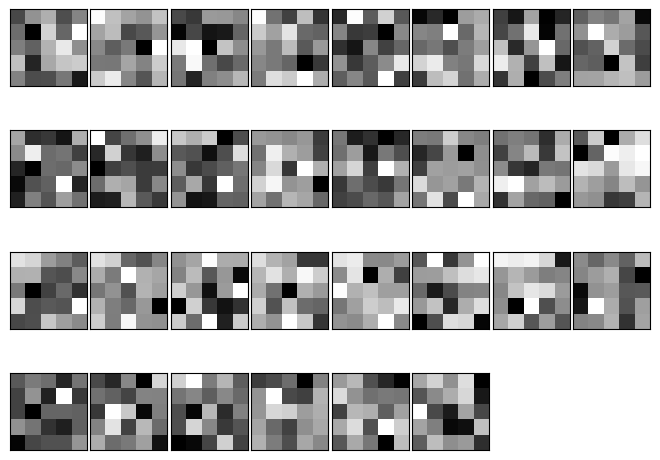

0.0
train acc, test acc | 0.11275, 0.1144


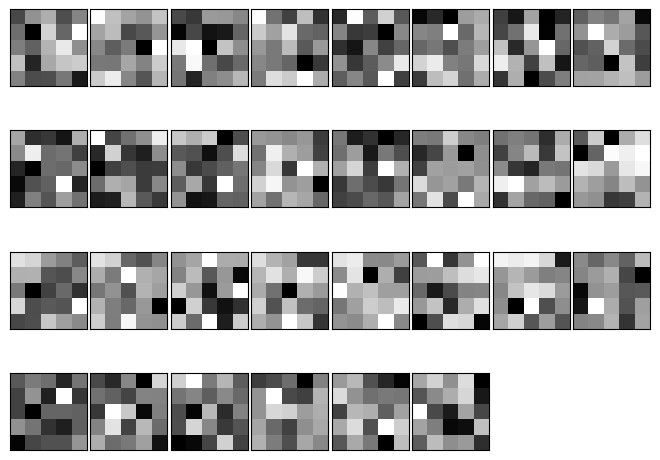

0.0001
train acc, test acc | 0.11236666666666667, 0.1135


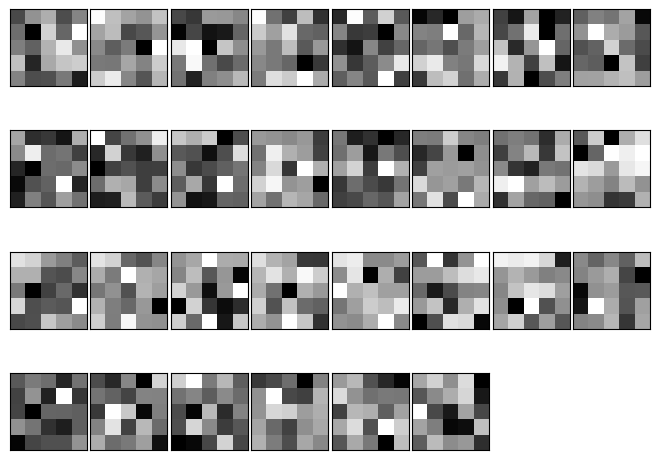

0.0002
train acc, test acc | 0.11236666666666667, 0.1135


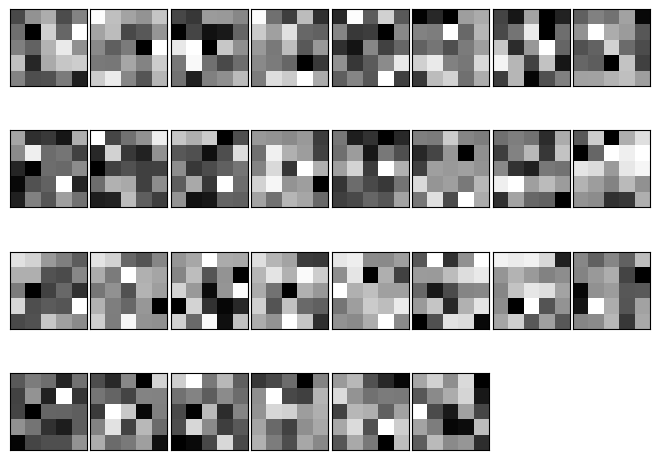

0.0003
train acc, test acc | 0.11236666666666667, 0.1135


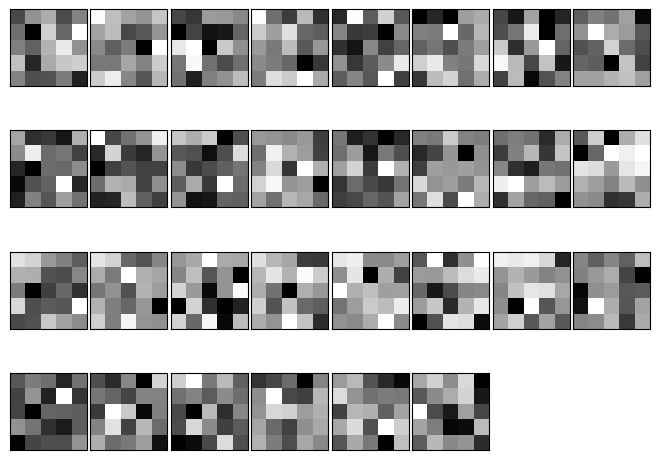

0.0004
train acc, test acc | 0.11236666666666667, 0.1135


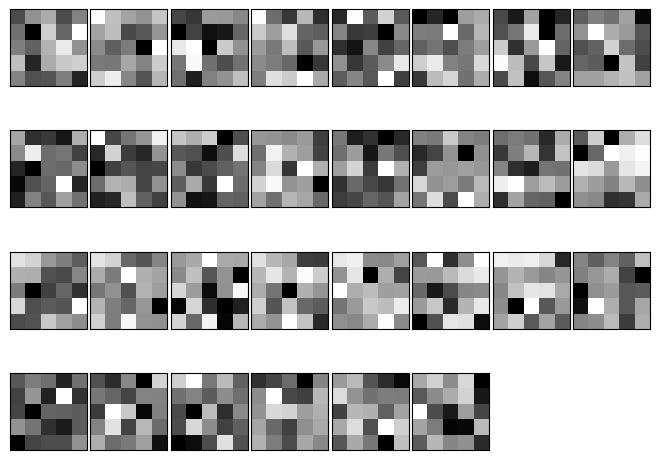

0.0005
train acc, test acc | 0.11236666666666667, 0.1135


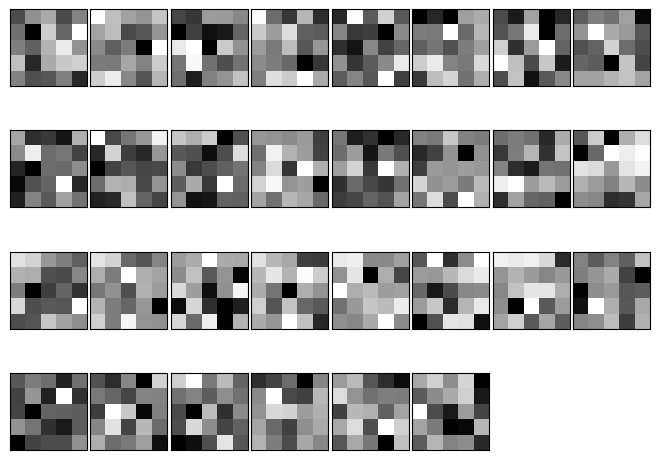

0.0006
train acc, test acc | 0.11236666666666667, 0.1135


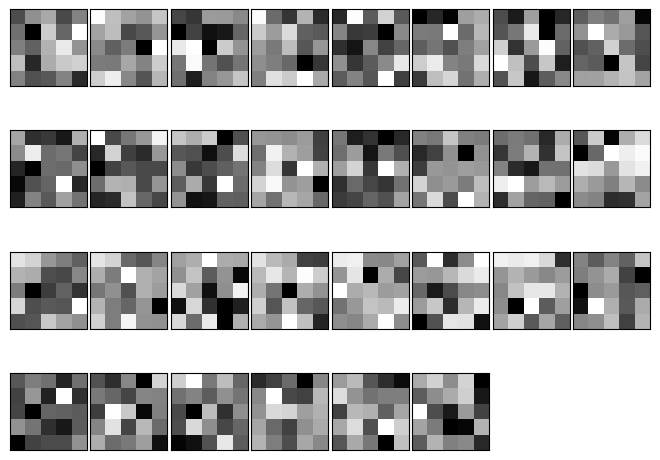

0.0007
train acc, test acc | 0.11236666666666667, 0.1135


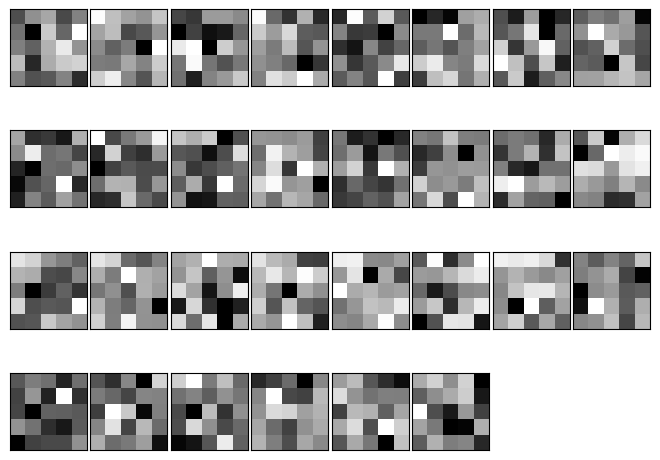

0.0008
train acc, test acc | 0.11236666666666667, 0.1135


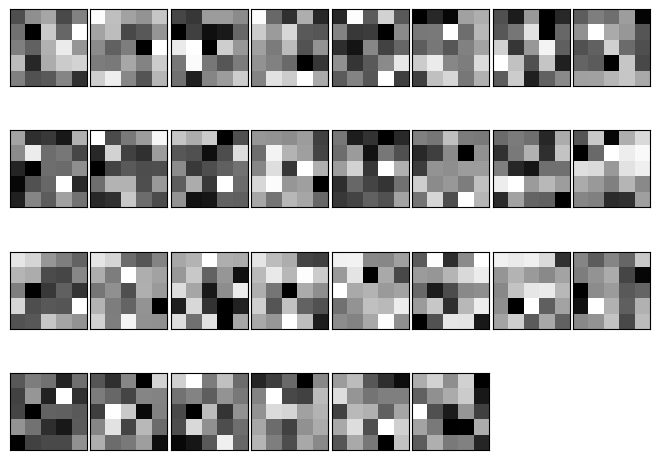

0.0009
train acc, test acc | 0.11236666666666667, 0.1135


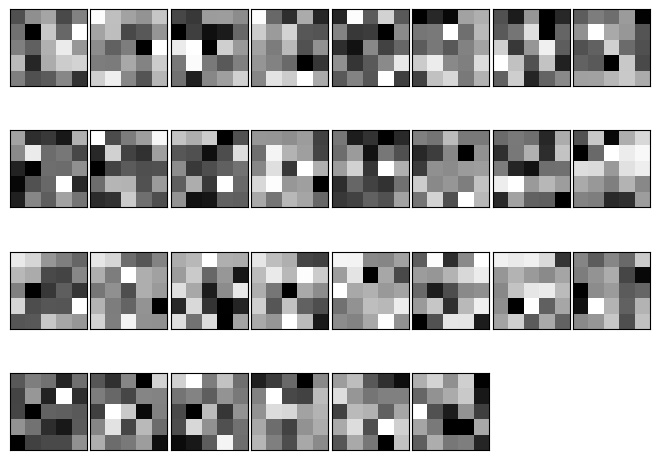

0.001
train acc, test acc | 0.11236666666666667, 0.1135


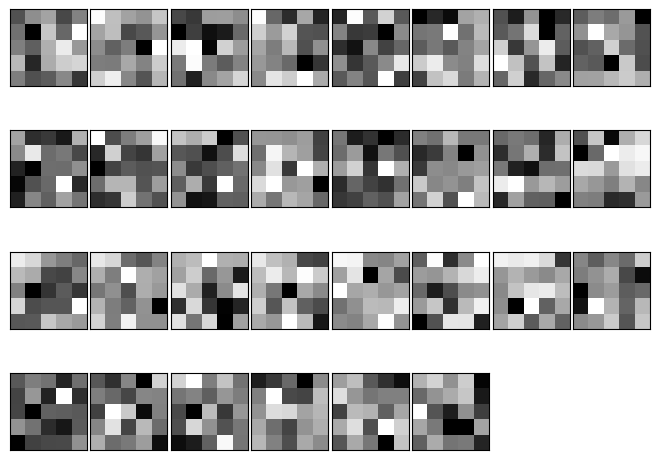

0.0011
train acc, test acc | 0.11236666666666667, 0.1135


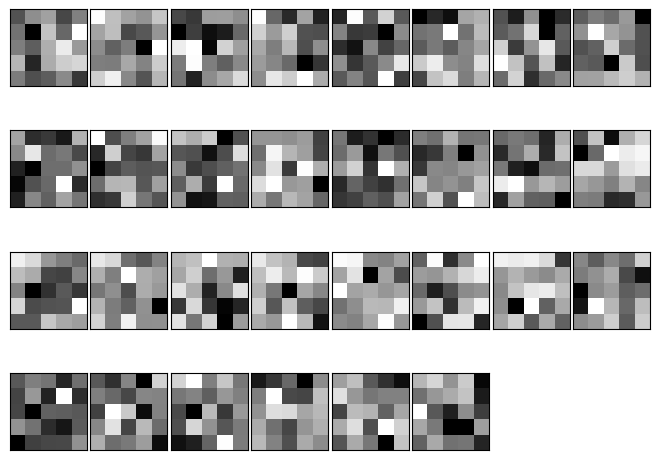

0.0012
train acc, test acc | 0.11236666666666667, 0.1135


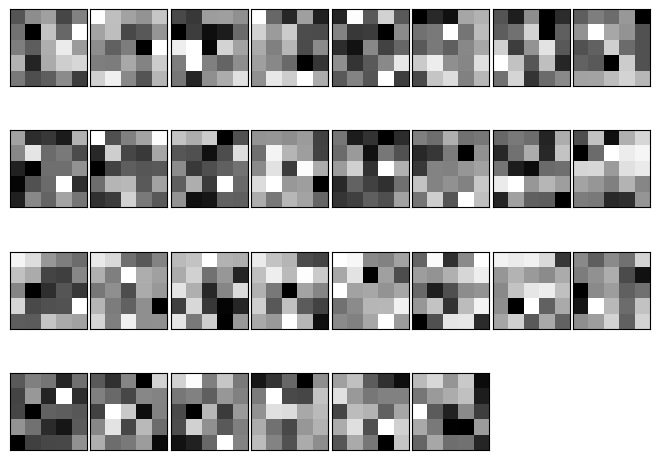

0.0013
train acc, test acc | 0.11236666666666667, 0.1135


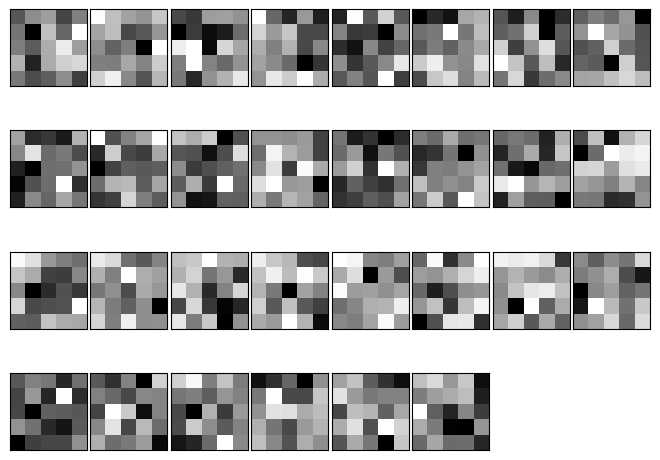

0.0014
train acc, test acc | 0.11245, 0.1135


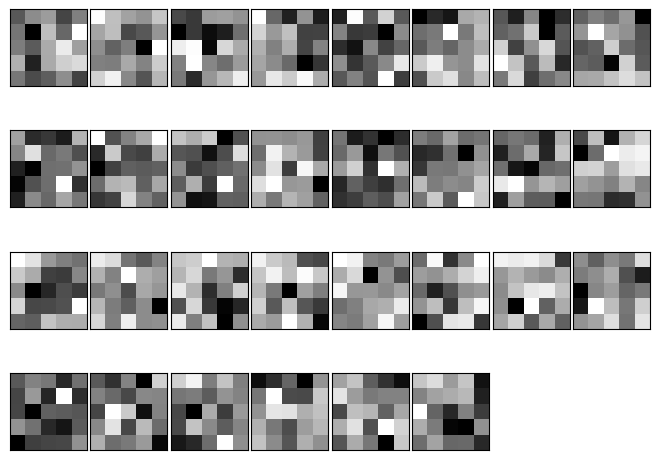

0.0015
train acc, test acc | 0.14998333333333333, 0.1527


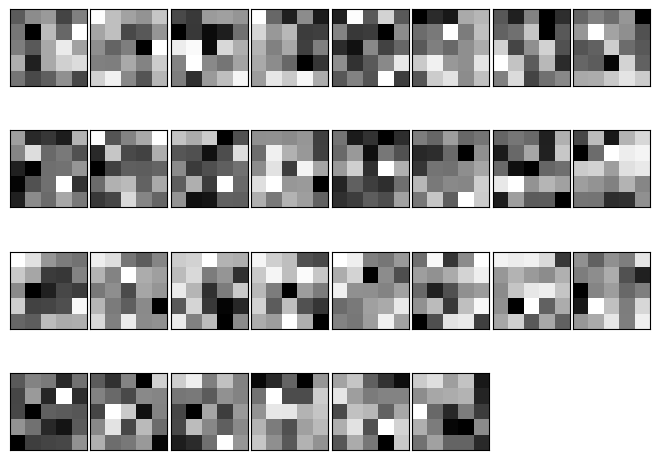

0.0016
train acc, test acc | 0.2605, 0.271


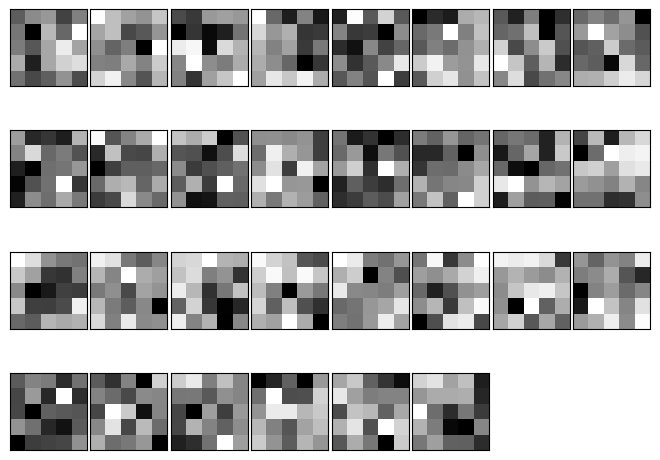

0.0017
train acc, test acc | 0.3640833333333333, 0.3682


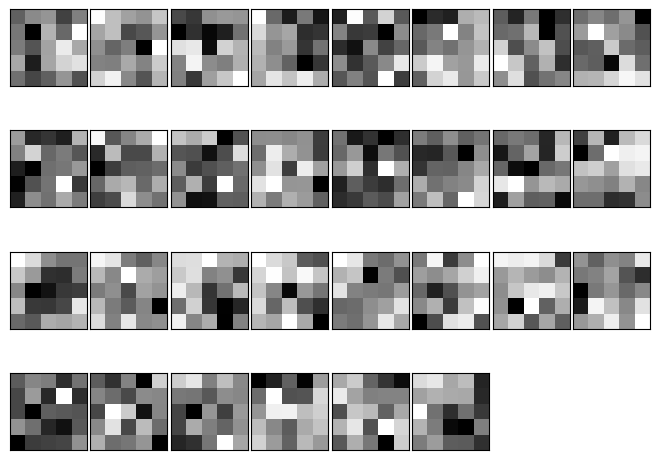

0.0018
train acc, test acc | 0.3814666666666667, 0.381


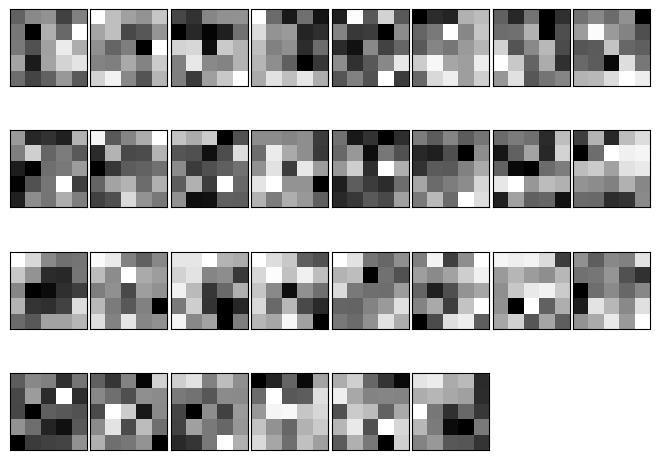

0.0019
train acc, test acc | 0.363, 0.3645


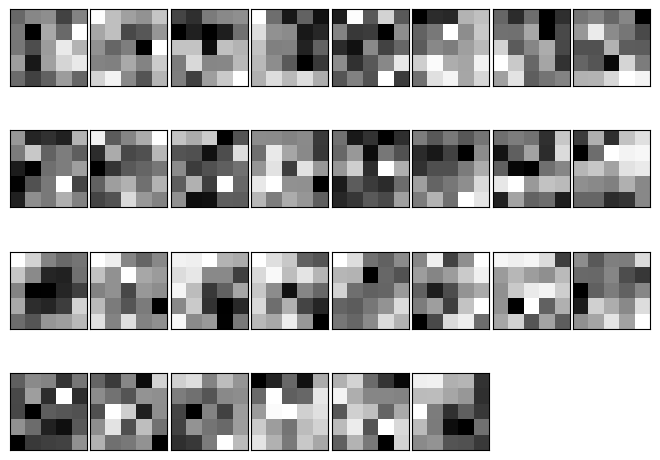

0.002
train acc, test acc | 0.3807833333333333, 0.3797


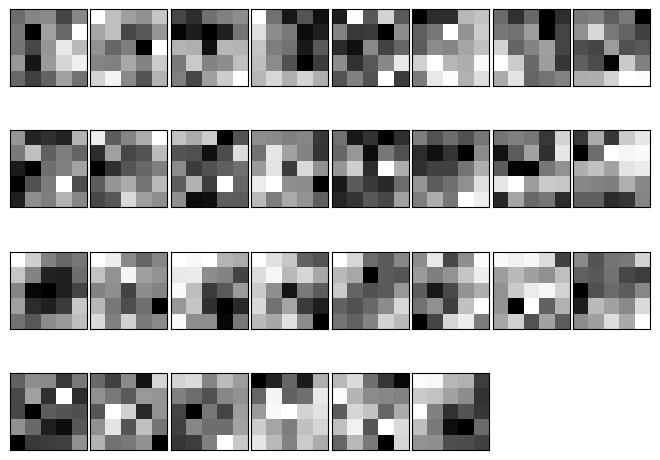

0.0021
train acc, test acc | 0.49, 0.5015


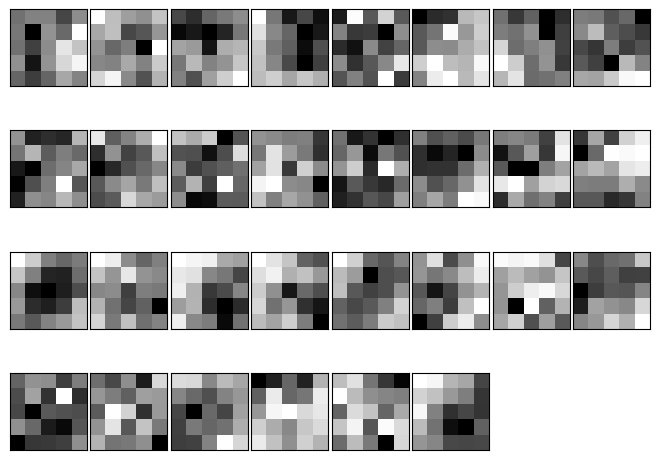

0.0022
train acc, test acc | 0.6067333333333333, 0.6135


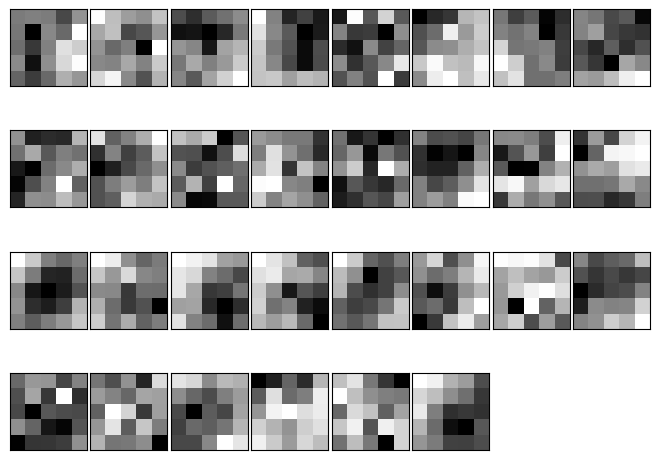

0.0023
train acc, test acc | 0.7020833333333333, 0.7121


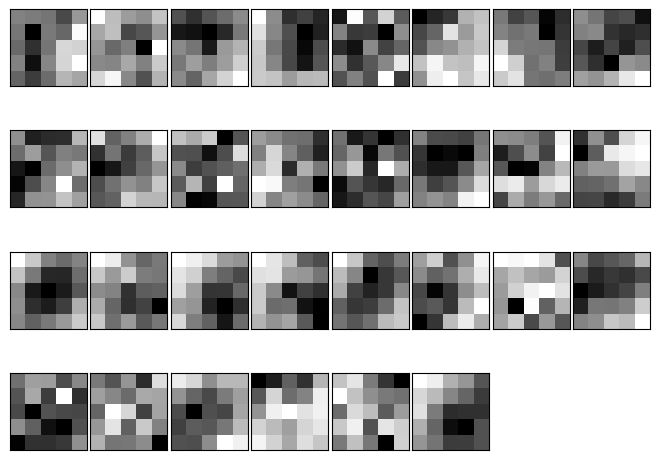

0.0024
train acc, test acc | 0.6064166666666667, 0.6228


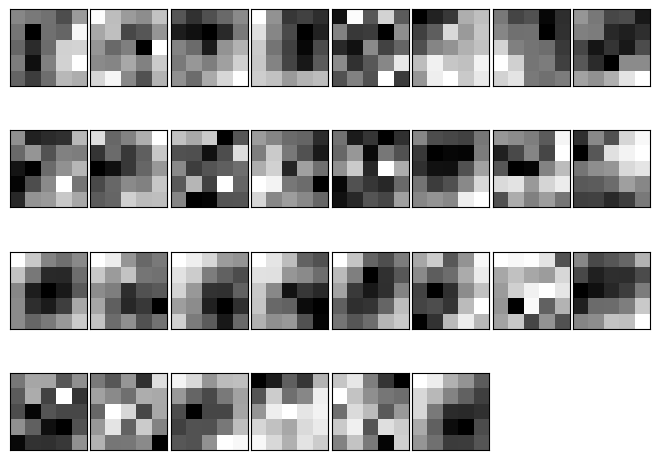

0.0025
train acc, test acc | 0.7696666666666667, 0.7746


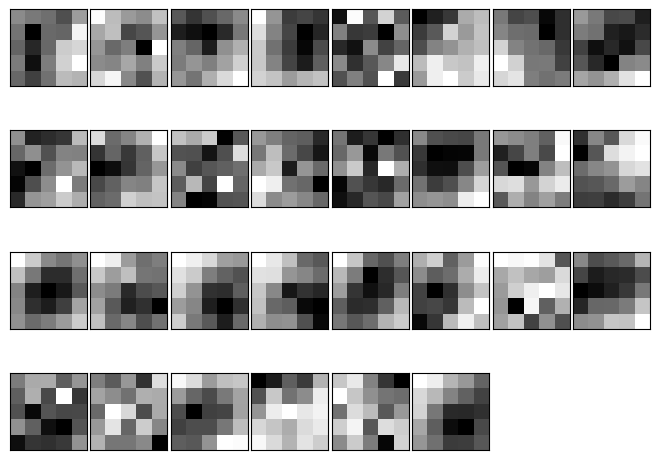

0.0026
train acc, test acc | 0.50805, 0.5006


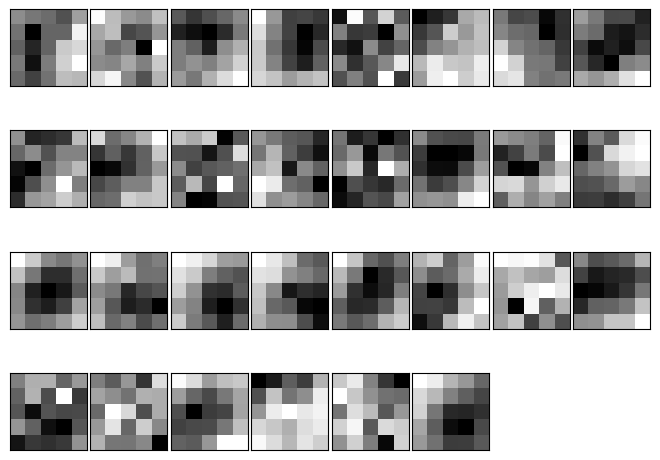

0.0027
train acc, test acc | 0.8104666666666667, 0.8188


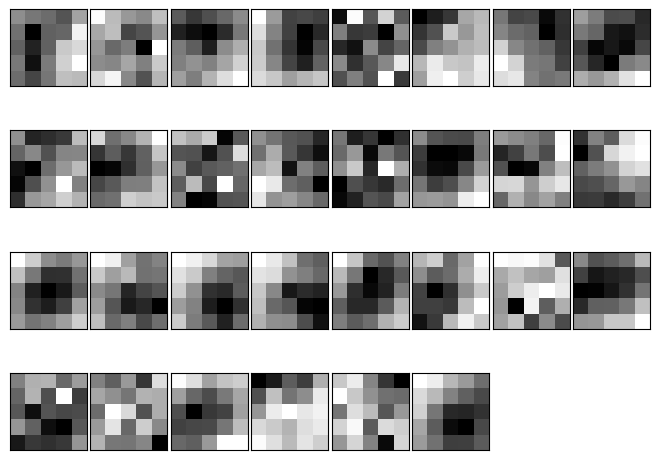

0.0028
train acc, test acc | 0.7077666666666667, 0.7175


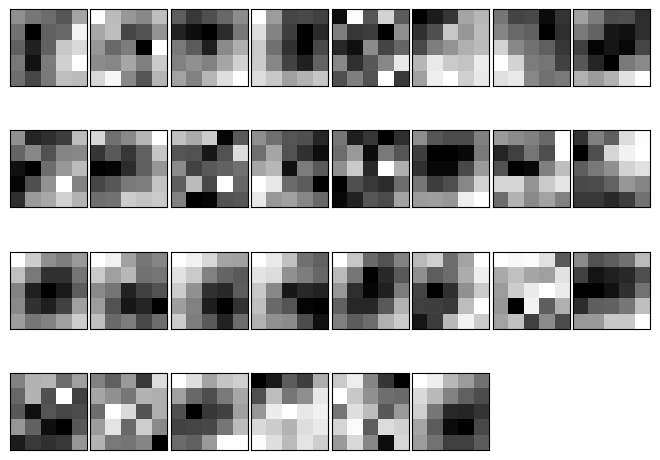

0.0029
train acc, test acc | 0.78485, 0.79


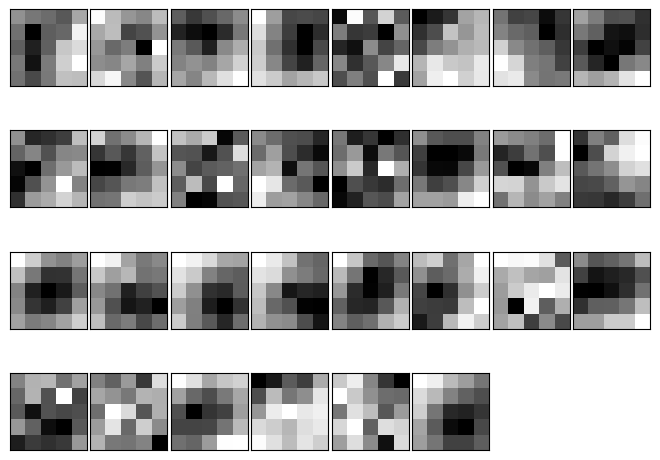

0.003
train acc, test acc | 0.7271833333333333, 0.7268


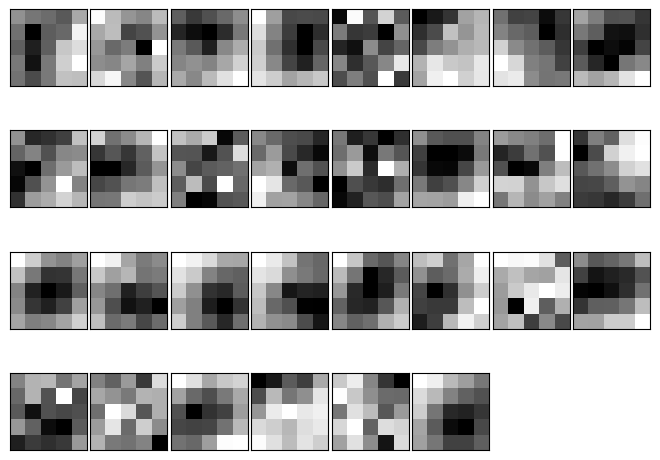

0.0031
train acc, test acc | 0.8389, 0.8414


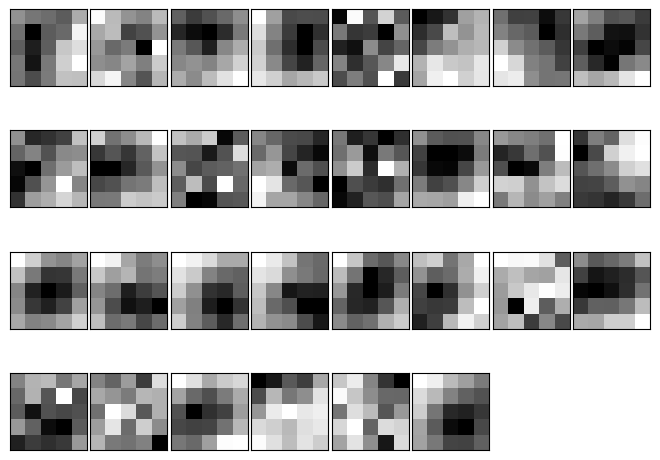

0.0032
train acc, test acc | 0.7966, 0.7993


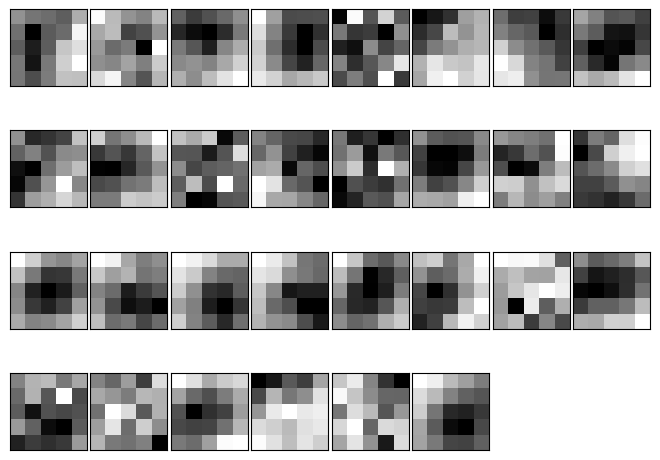

0.0033
train acc, test acc | 0.8364666666666667, 0.8413


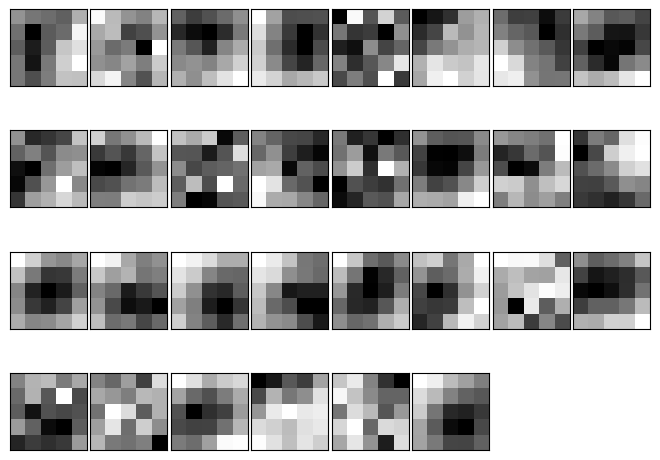

0.0034
train acc, test acc | 0.86295, 0.8713


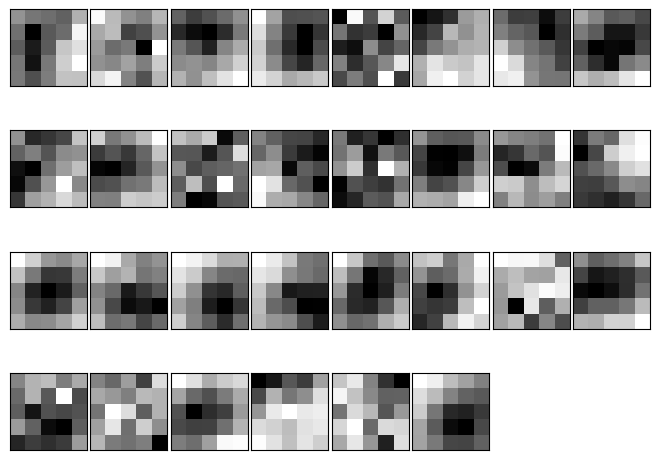

0.0035
train acc, test acc | 0.82125, 0.8286


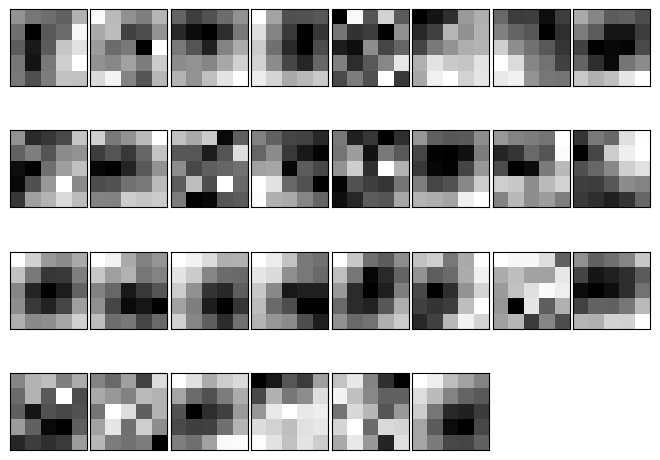

0.0036
train acc, test acc | 0.8517166666666667, 0.8596


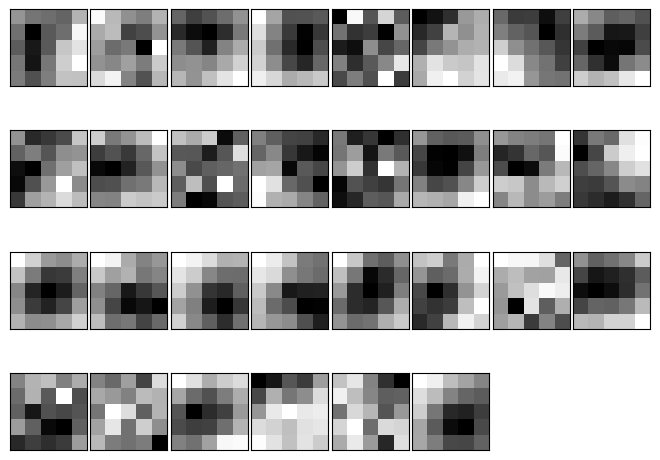

0.0037
train acc, test acc | 0.8630833333333333, 0.8711


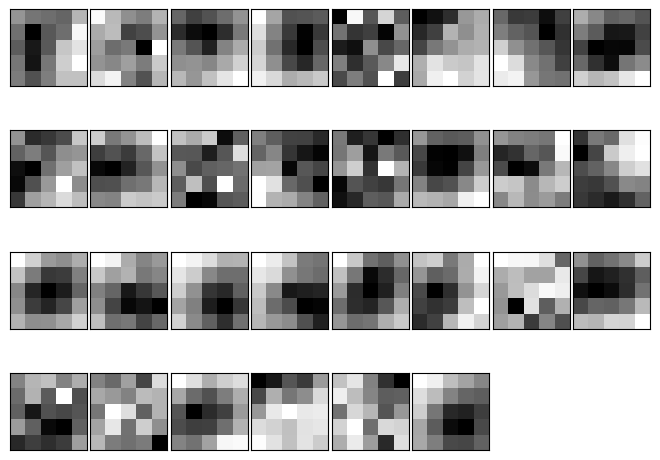

0.0038
train acc, test acc | 0.8626666666666667, 0.8692


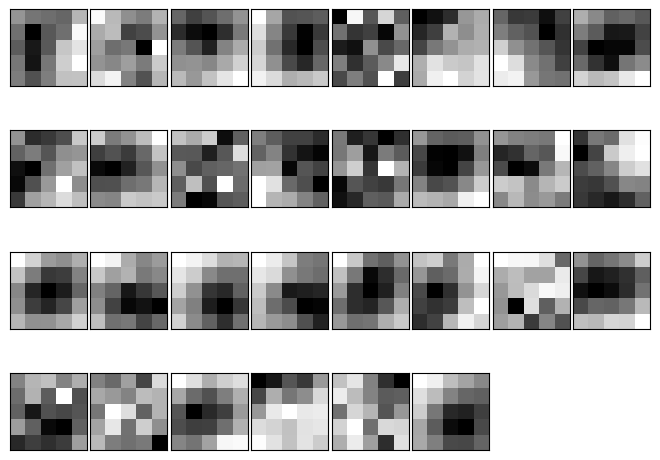

0.0039
train acc, test acc | 0.8555166666666667, 0.862


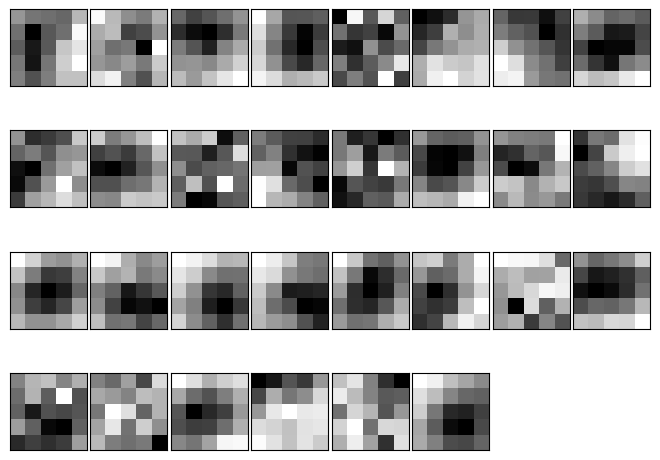

0.004
train acc, test acc | 0.8855, 0.8948


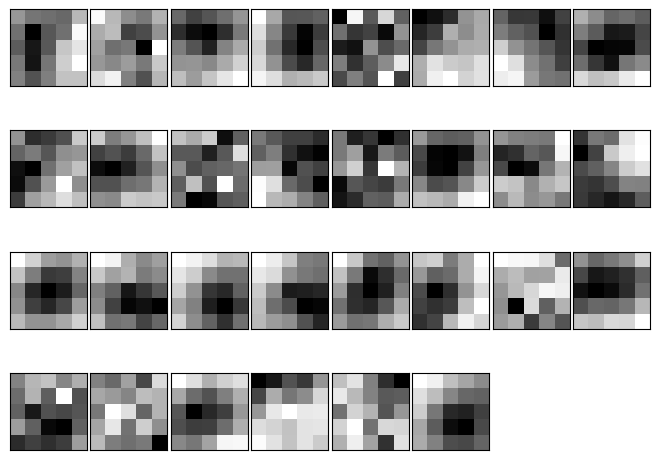

0.0041
train acc, test acc | 0.8915666666666666, 0.9


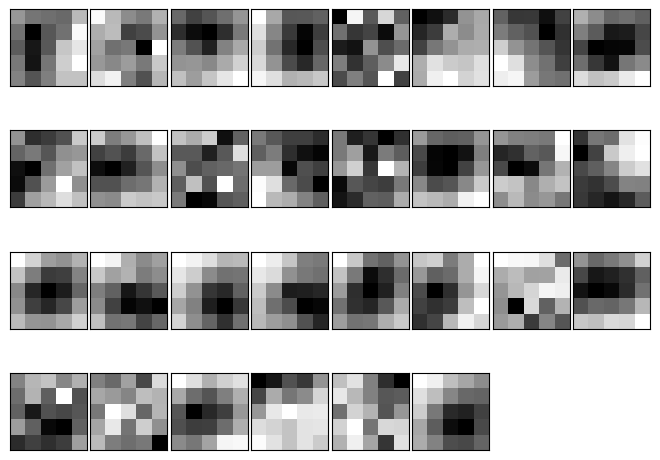

0.0042
train acc, test acc | 0.8858, 0.8947


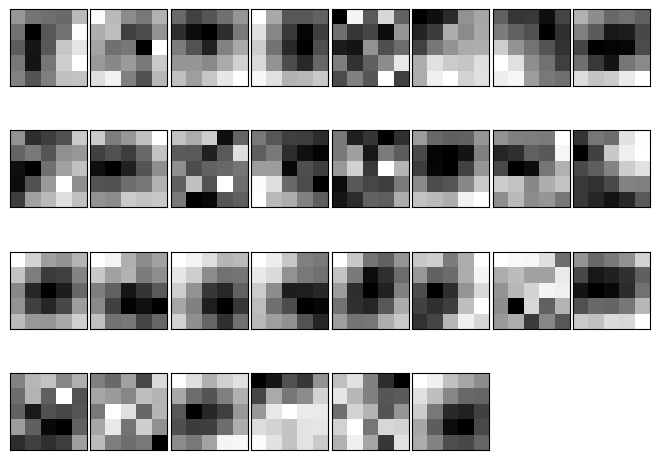

0.0043
train acc, test acc | 0.87275, 0.8804


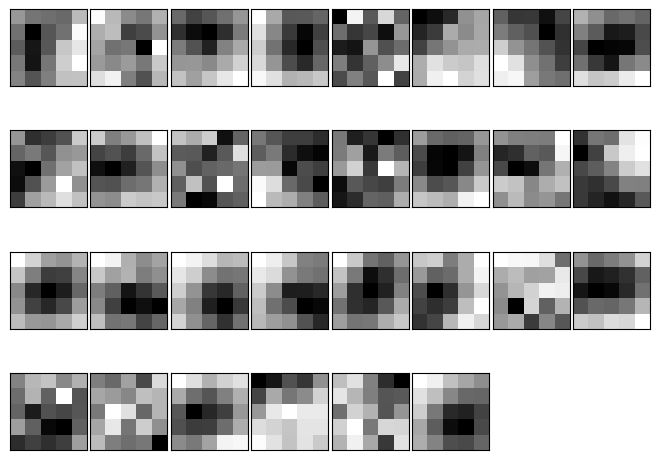

0.0044
train acc, test acc | 0.8931166666666667, 0.8998


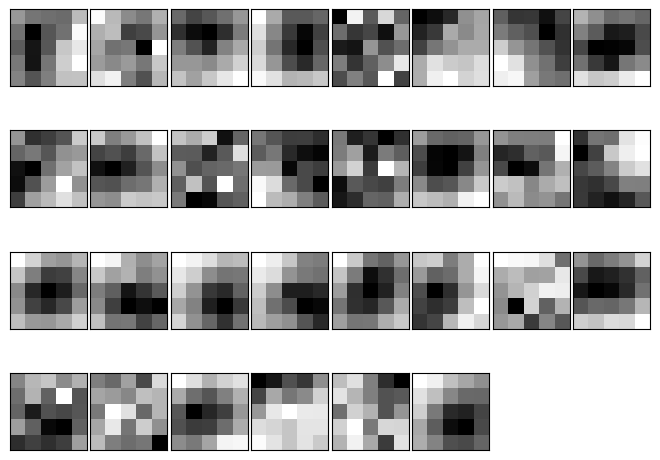

0.0045
train acc, test acc | 0.8957166666666667, 0.9011


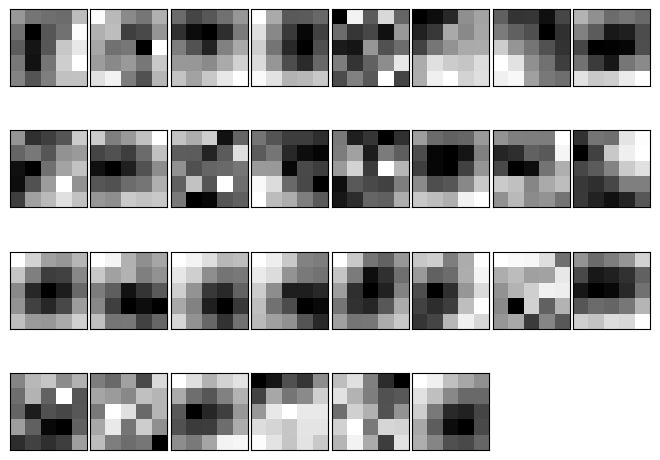

0.0046
train acc, test acc | 0.9001, 0.9068


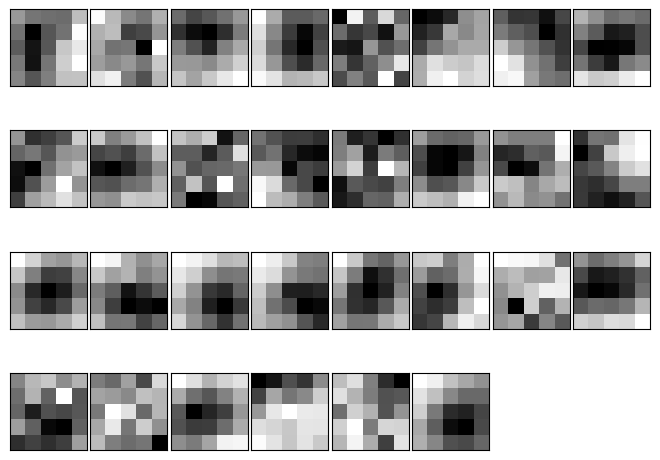

0.0047
train acc, test acc | 0.8997333333333334, 0.9071


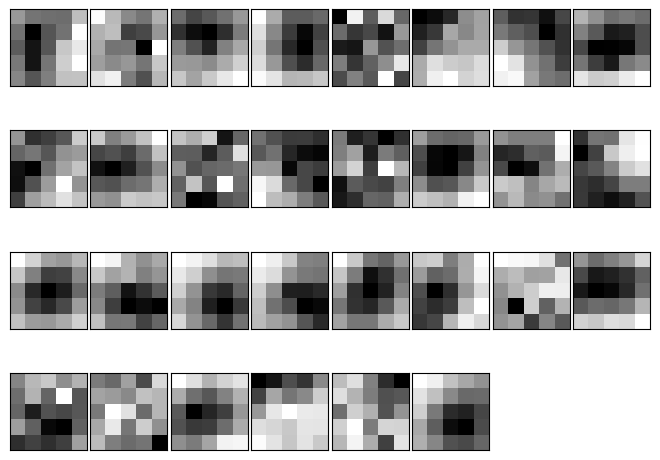

0.0048
train acc, test acc | 0.87735, 0.8831


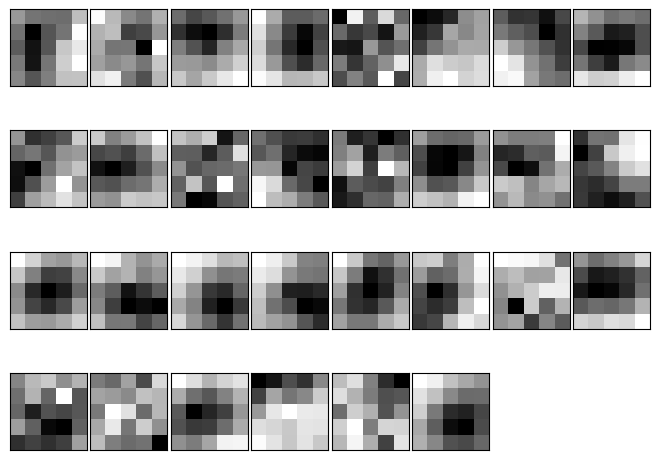

0.0049
train acc, test acc | 0.8755166666666667, 0.8811


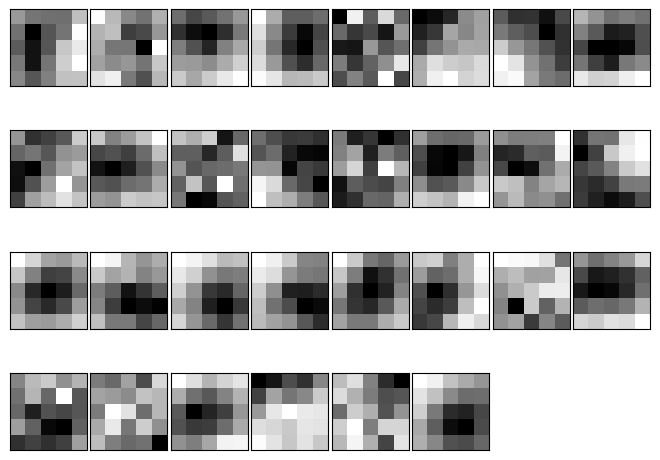

0.005
train acc, test acc | 0.9046833333333333, 0.9121


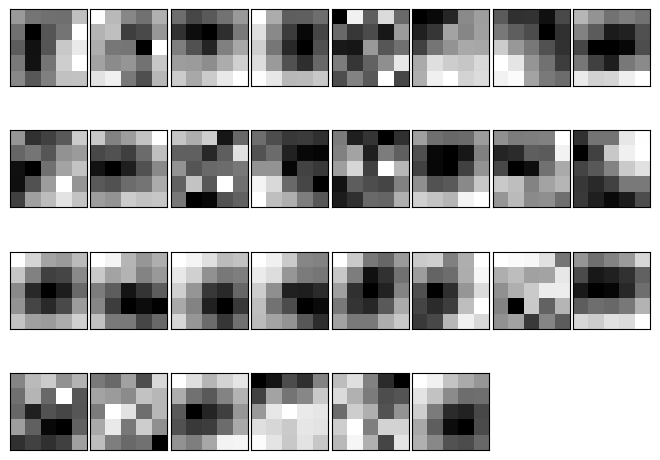

0.0051
train acc, test acc | 0.90625, 0.9125


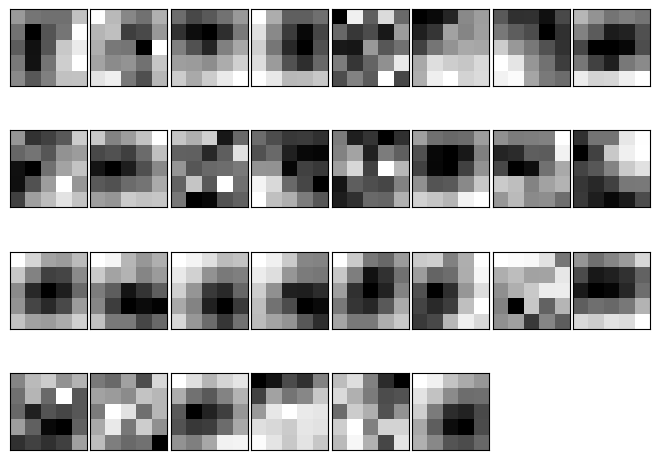

0.0052
train acc, test acc | 0.90935, 0.916


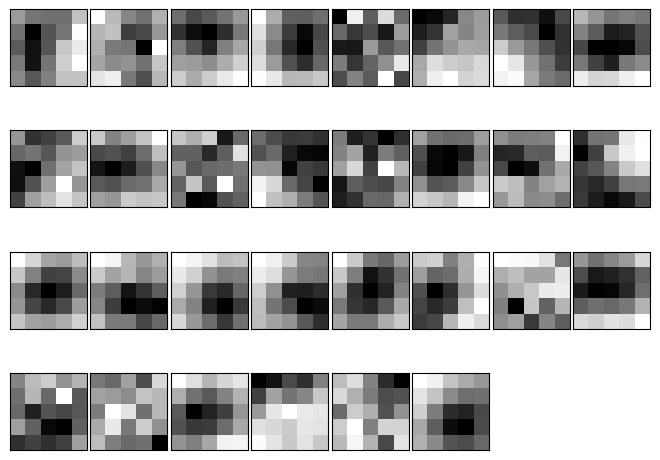

0.0053
train acc, test acc | 0.9089833333333334, 0.9161


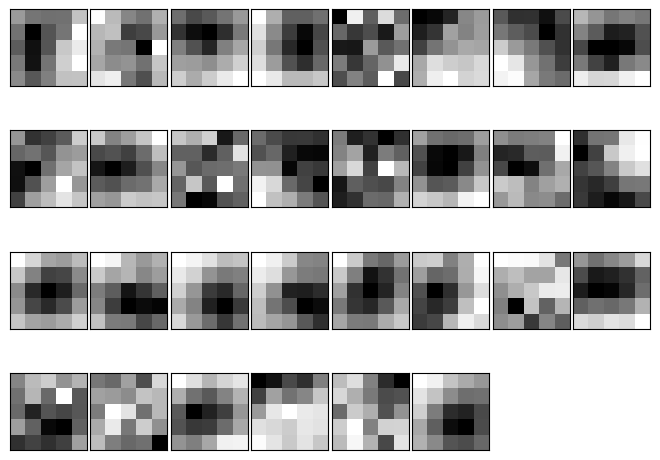

0.0054
train acc, test acc | 0.9089, 0.9175


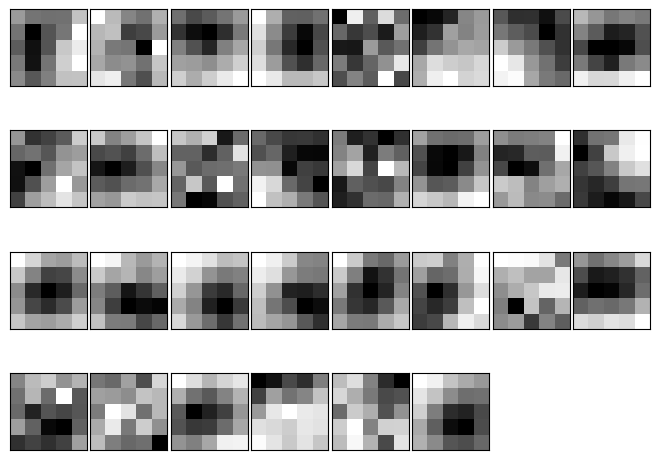

0.0055
train acc, test acc | 0.912, 0.9187


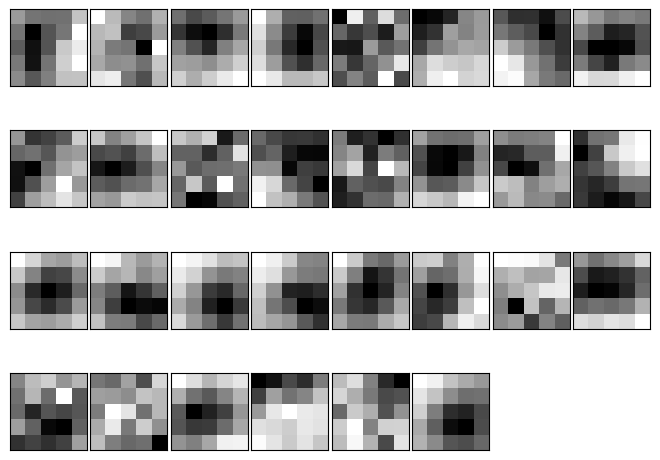

0.0056
train acc, test acc | 0.9050166666666667, 0.913


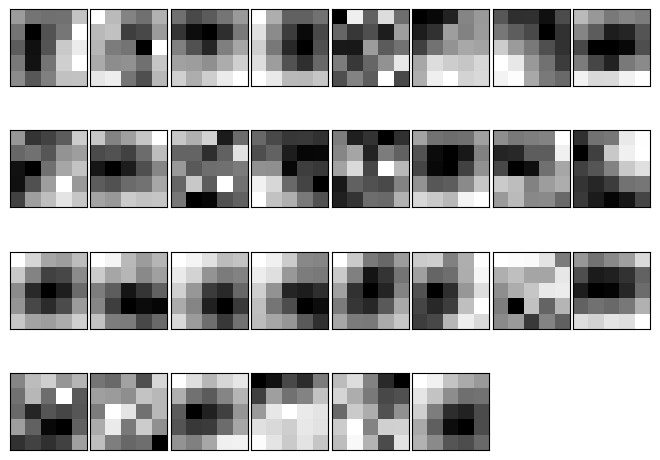

0.0057
train acc, test acc | 0.906, 0.9136


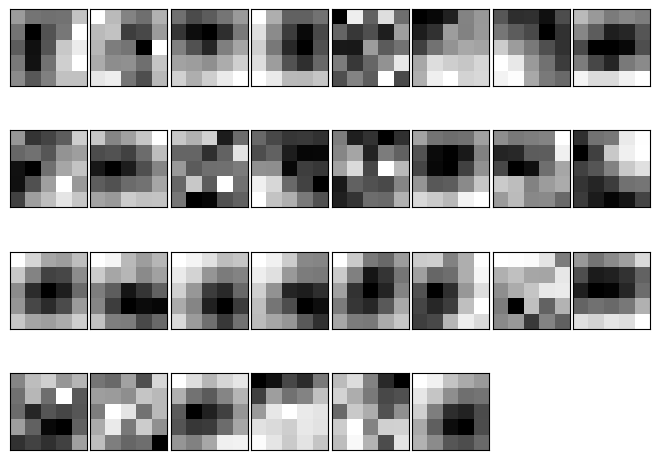

0.0058
train acc, test acc | 0.9140833333333334, 0.921


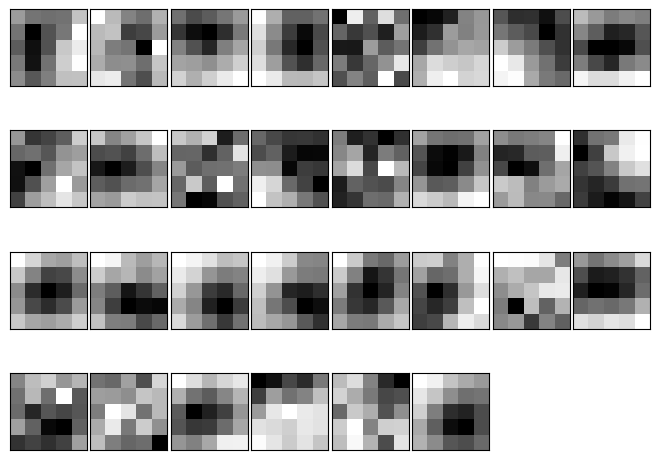

0.0059
train acc, test acc | 0.9148333333333334, 0.9206


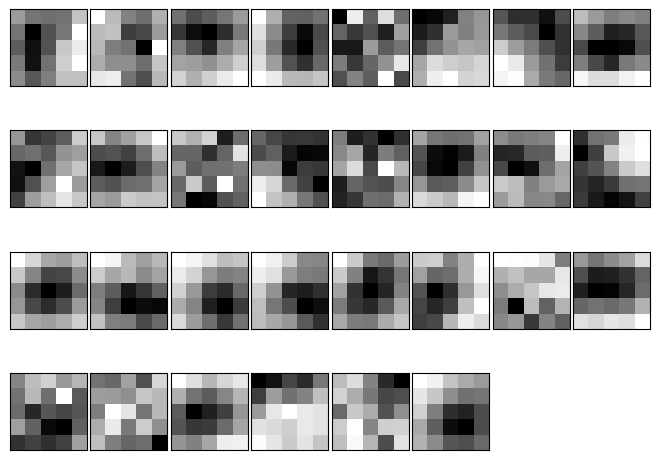

0.006
train acc, test acc | 0.9038833333333334, 0.9118


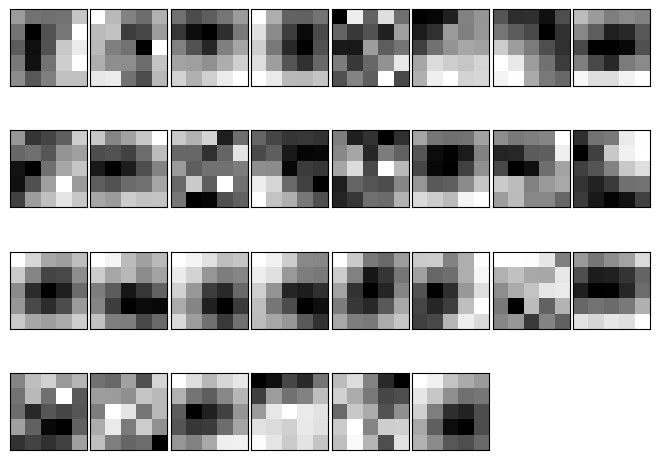

0.0061
train acc, test acc | 0.9107333333333333, 0.9166


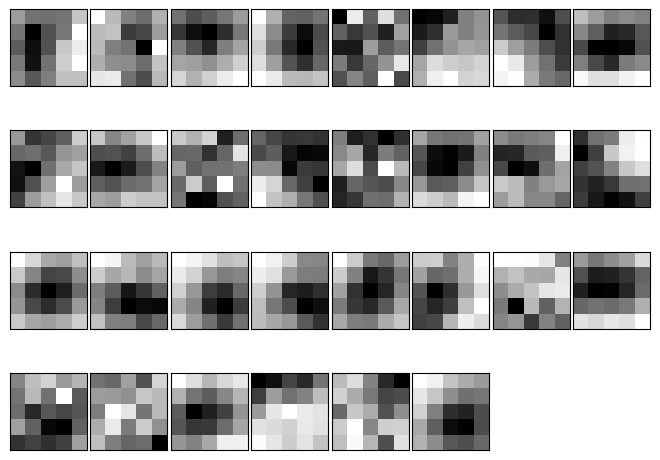

0.0062
train acc, test acc | 0.9195166666666666, 0.9265


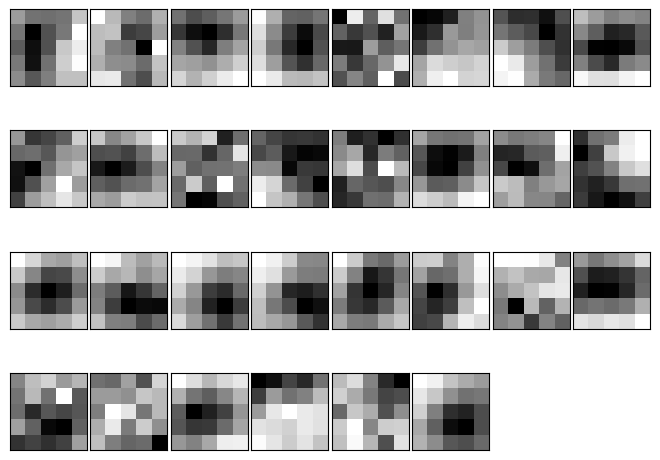

0.0063
train acc, test acc | 0.9200166666666667, 0.926


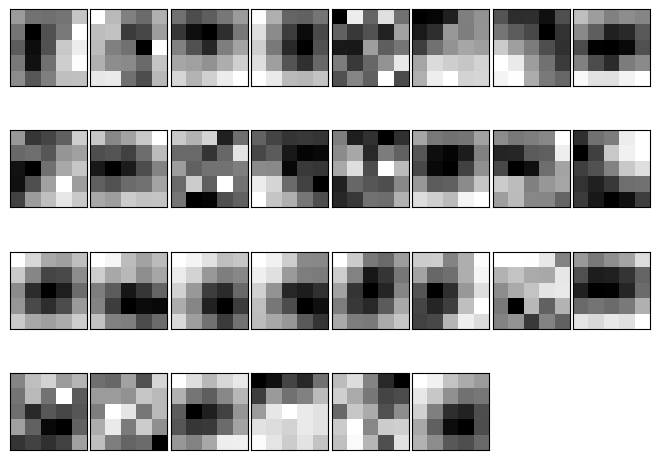

0.0064
train acc, test acc | 0.9215166666666667, 0.9281


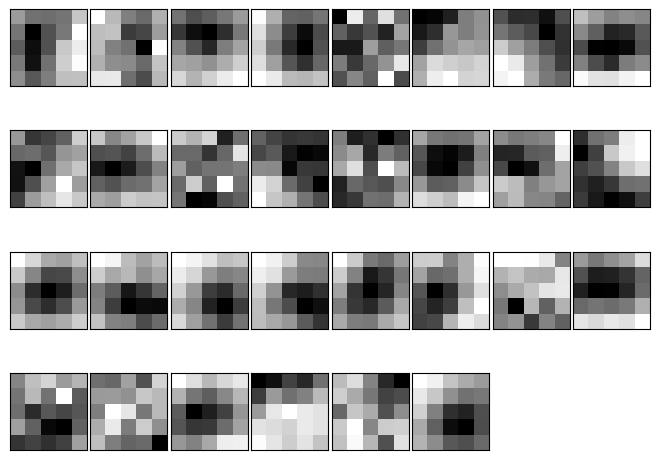

0.0065
train acc, test acc | 0.9178166666666666, 0.9245


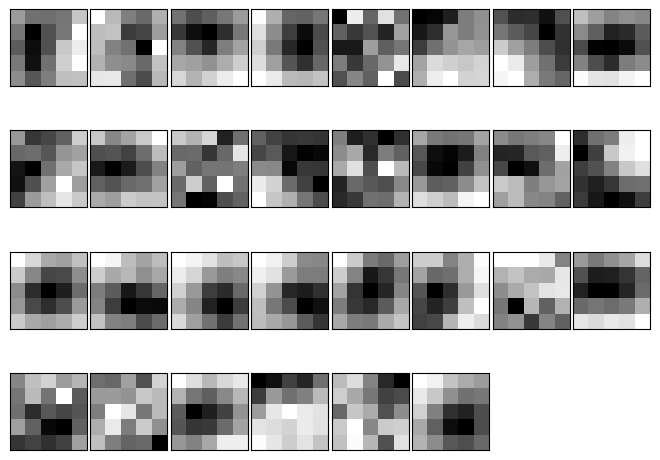

0.0066
train acc, test acc | 0.9203666666666667, 0.9258


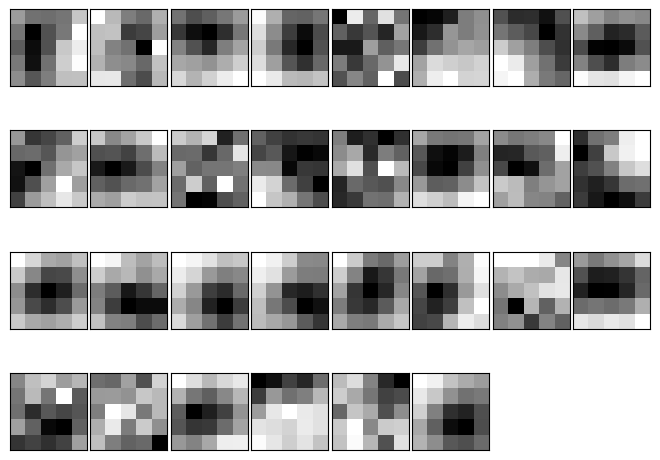

0.0067
train acc, test acc | 0.9221166666666667, 0.9281


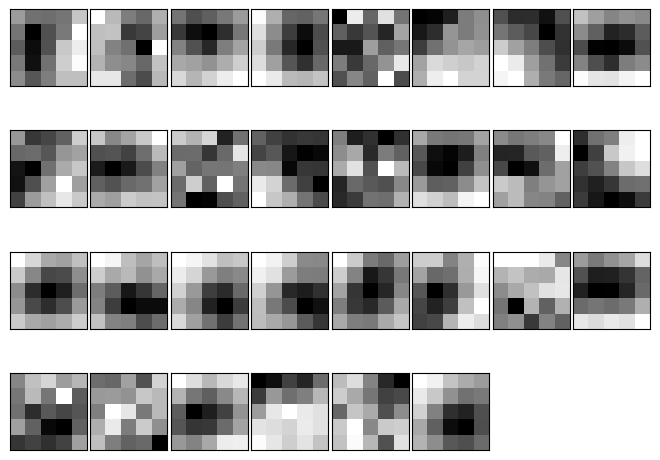

0.0068
train acc, test acc | 0.9183333333333333, 0.9241


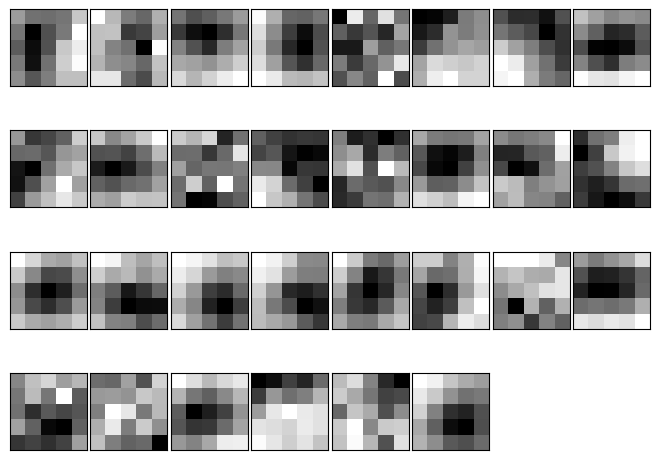

0.0069
train acc, test acc | 0.9202166666666667, 0.9275


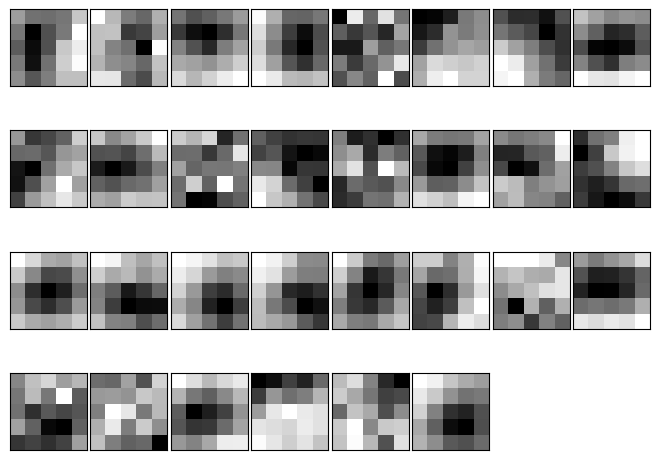

0.007
train acc, test acc | 0.91995, 0.9264


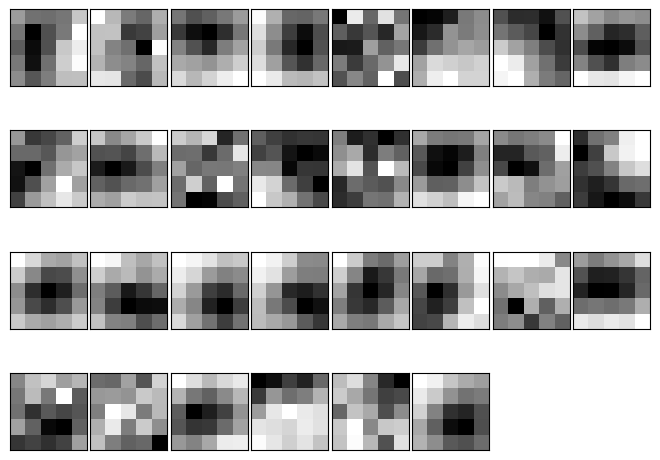

0.0071
train acc, test acc | 0.9284666666666667, 0.9341


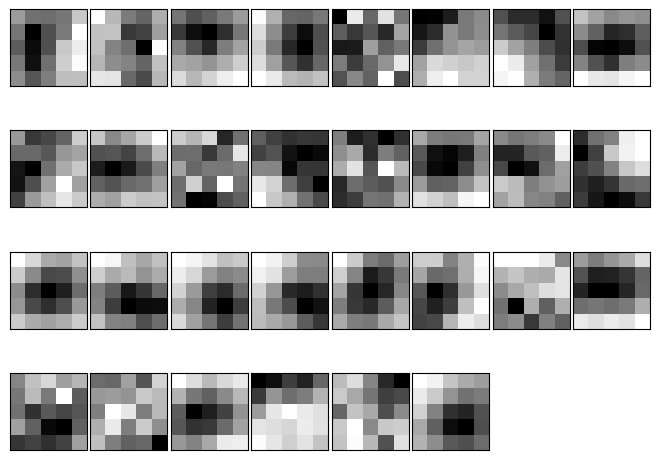

0.0072
train acc, test acc | 0.92925, 0.9347


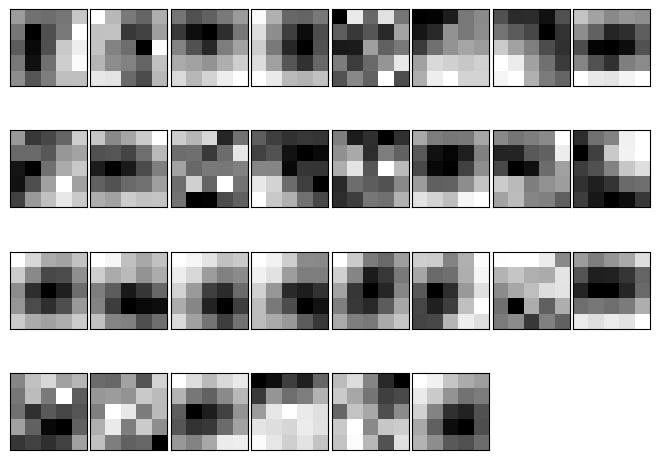

0.0073
train acc, test acc | 0.9305166666666667, 0.935


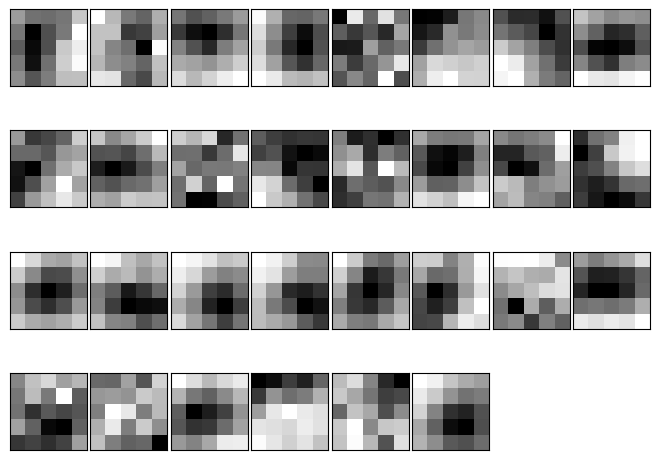

0.0074
train acc, test acc | 0.9309833333333334, 0.9356


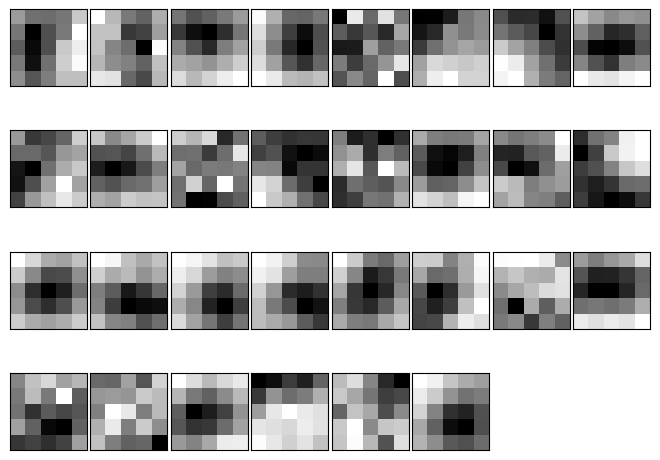

0.0075
train acc, test acc | 0.9304166666666667, 0.9372


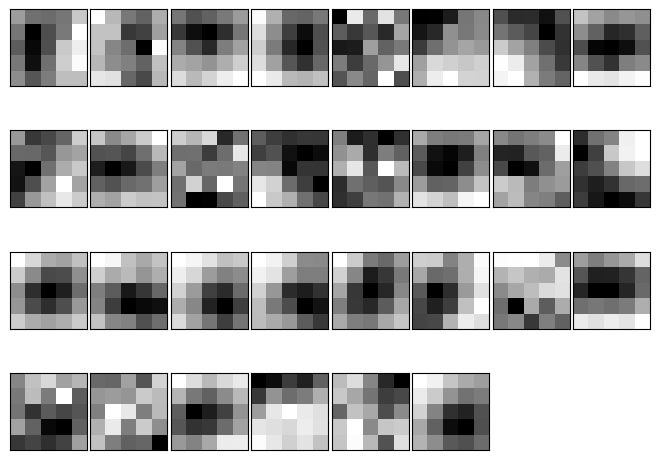

0.0076
train acc, test acc | 0.9301333333333334, 0.9349


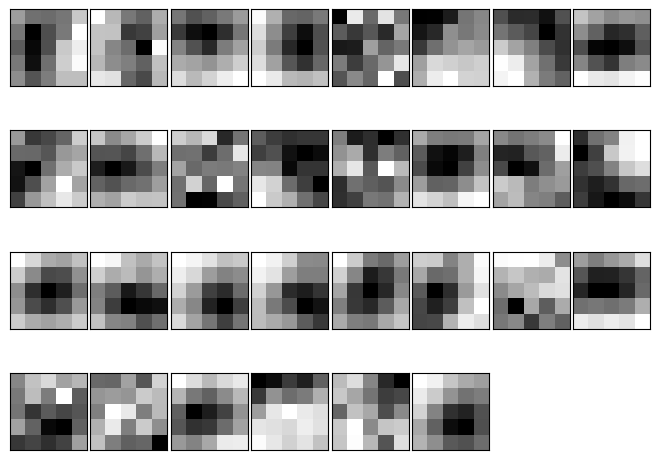

0.0077
train acc, test acc | 0.9266, 0.9317


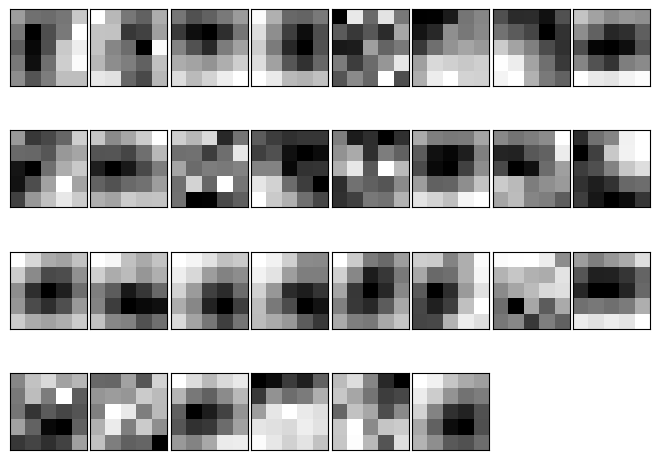

0.0078
train acc, test acc | 0.90515, 0.9107


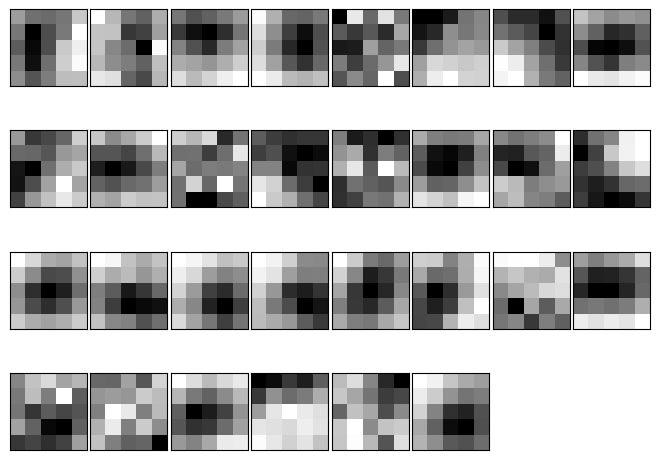

0.0079
train acc, test acc | 0.9331333333333334, 0.9387


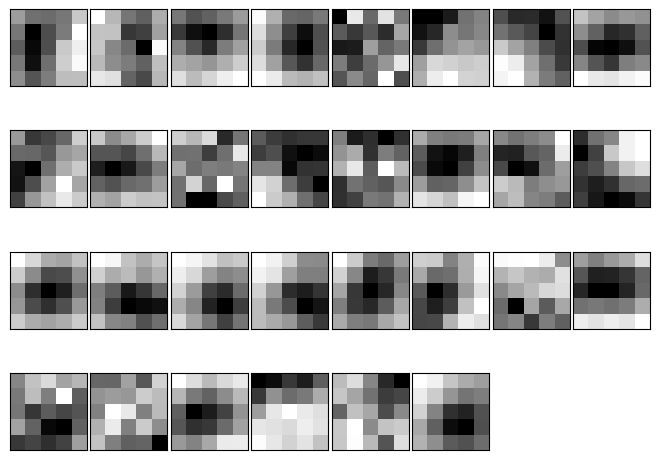

0.008
train acc, test acc | 0.9350666666666667, 0.9411


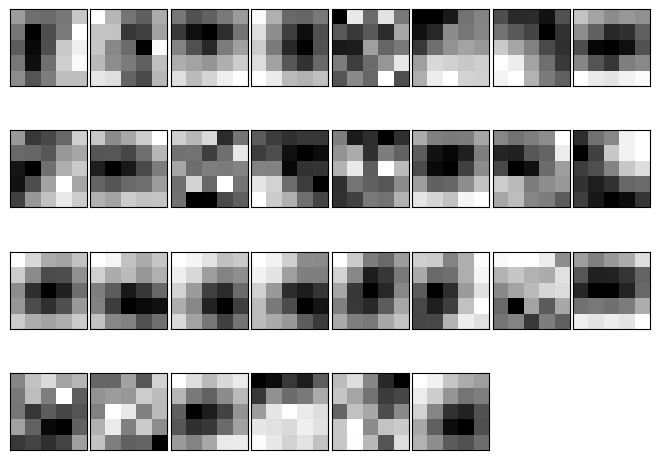

0.0081
train acc, test acc | 0.9352333333333334, 0.9416


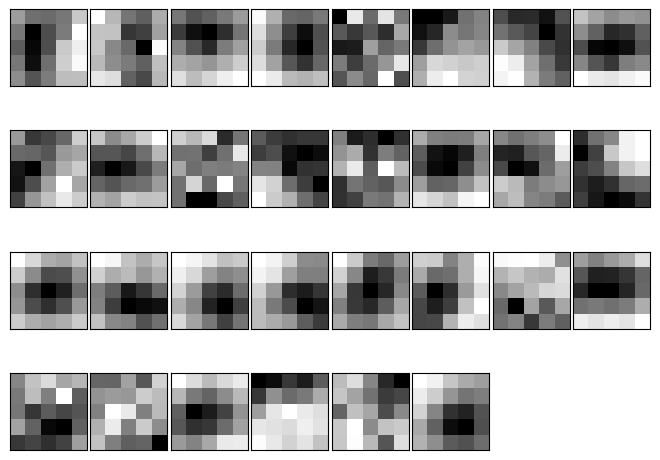

0.0082
train acc, test acc | 0.9351666666666667, 0.9414


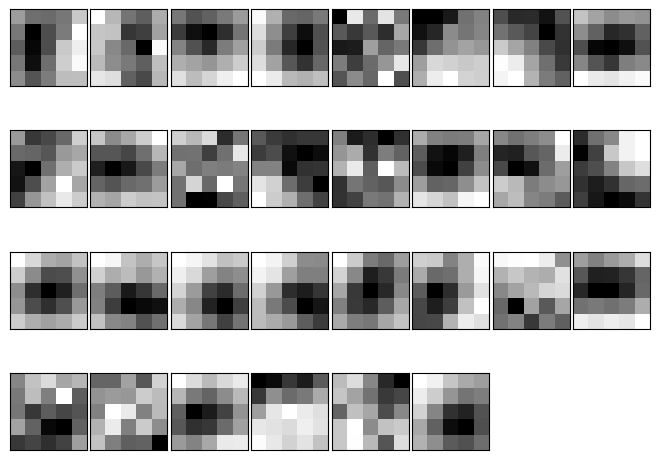

0.0083
train acc, test acc | 0.9363, 0.9432


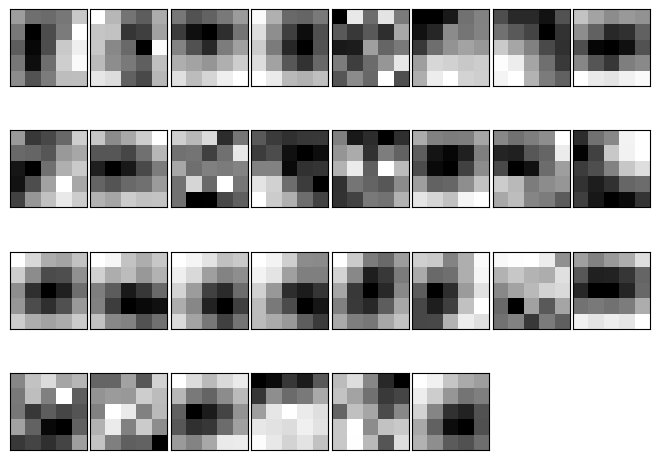

0.0084
train acc, test acc | 0.93735, 0.9432


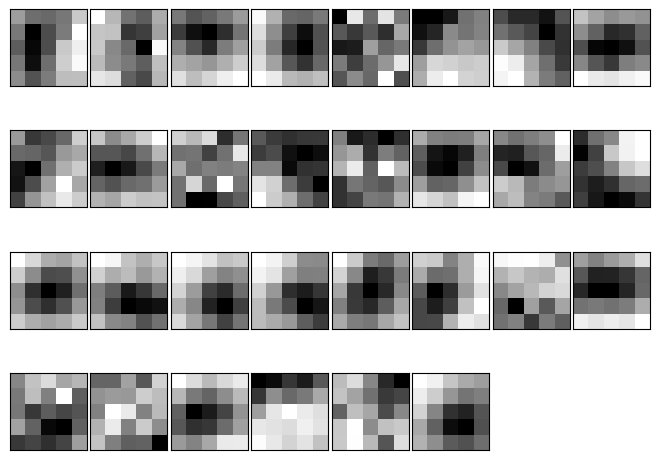

0.0085
train acc, test acc | 0.9379166666666666, 0.9431


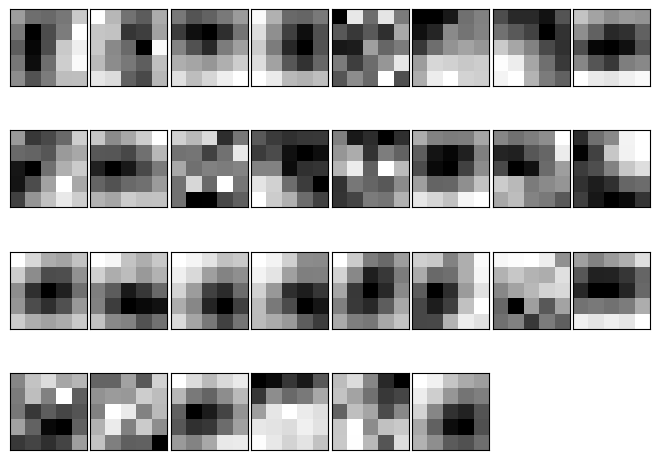

0.0086
train acc, test acc | 0.9381333333333334, 0.9432


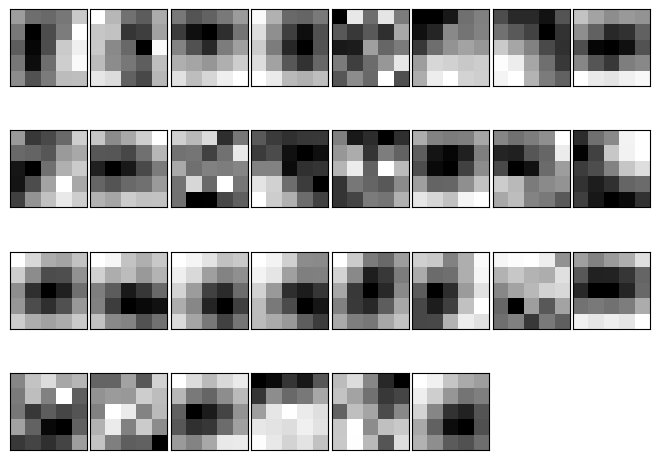

0.0087
train acc, test acc | 0.9360166666666667, 0.9411


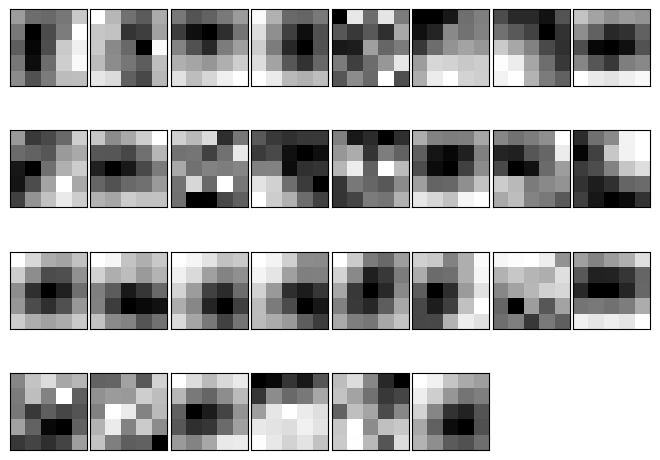

0.0088
train acc, test acc | 0.9384833333333333, 0.9439


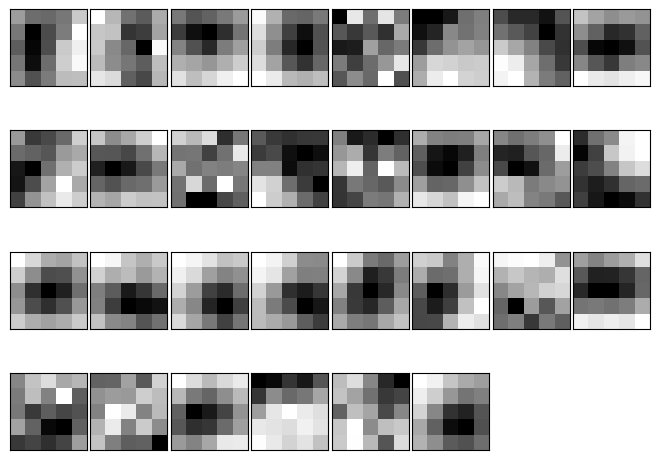

0.0089
train acc, test acc | 0.94, 0.9445


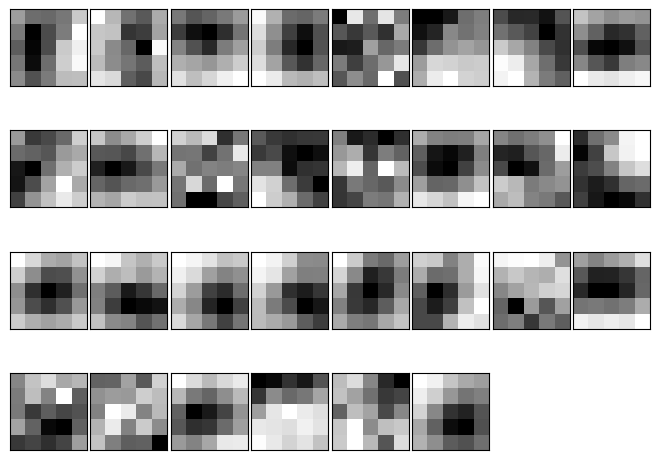

0.009
train acc, test acc | 0.9411666666666667, 0.9454


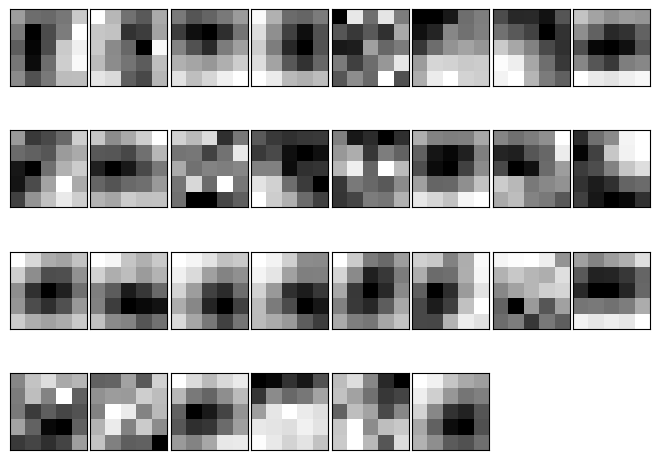

0.0091
train acc, test acc | 0.9416166666666667, 0.9471


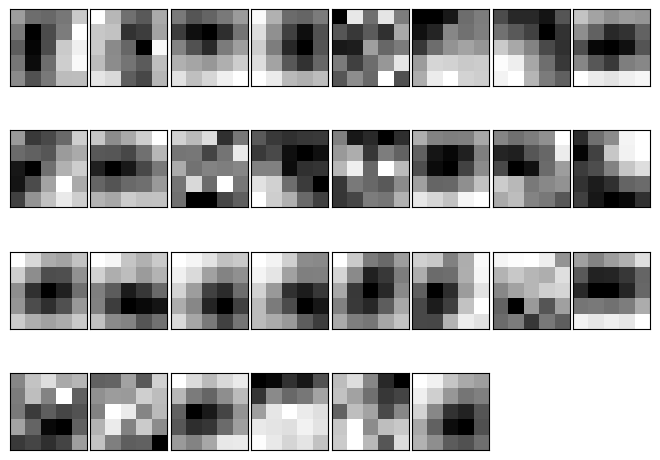

0.0092
train acc, test acc | 0.9421666666666667, 0.9465


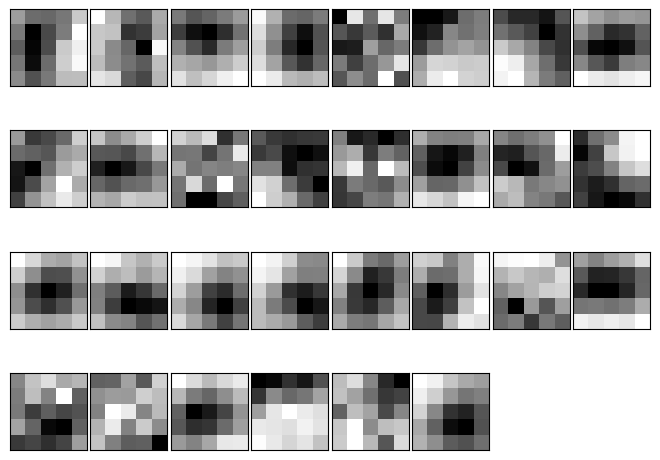

0.0093
train acc, test acc | 0.9413666666666667, 0.9452


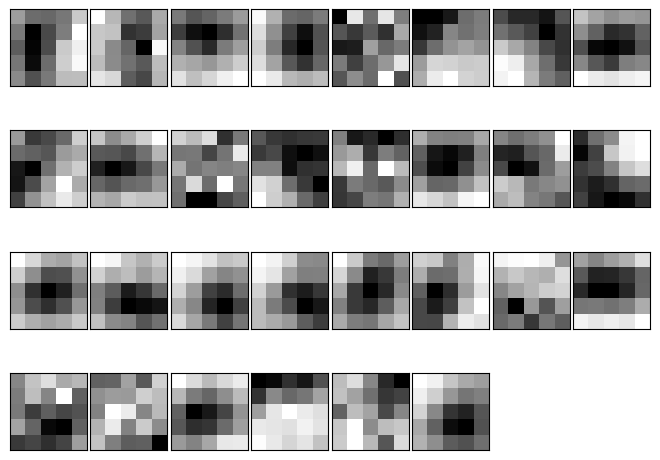

0.0094
train acc, test acc | 0.9397166666666666, 0.9436


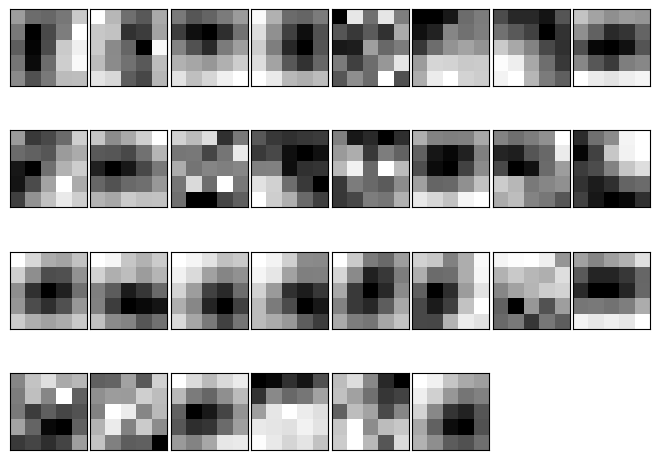

0.0095
train acc, test acc | 0.94015, 0.945


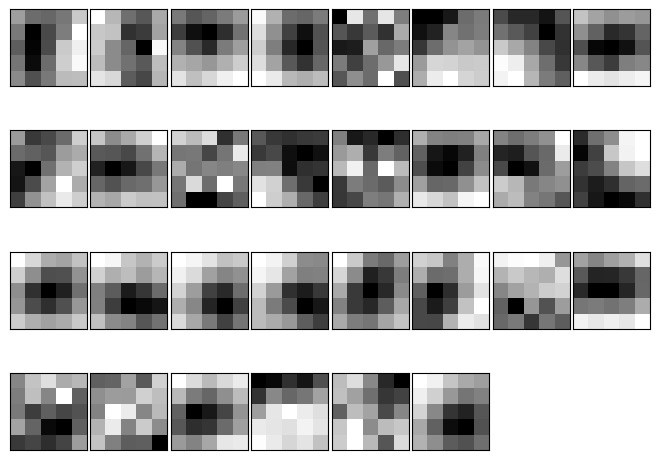

0.0096
train acc, test acc | 0.9397833333333333, 0.9463


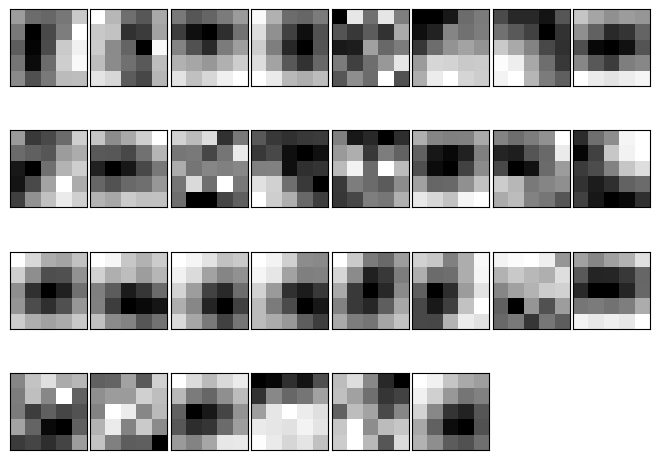

0.0097
train acc, test acc | 0.9313, 0.935


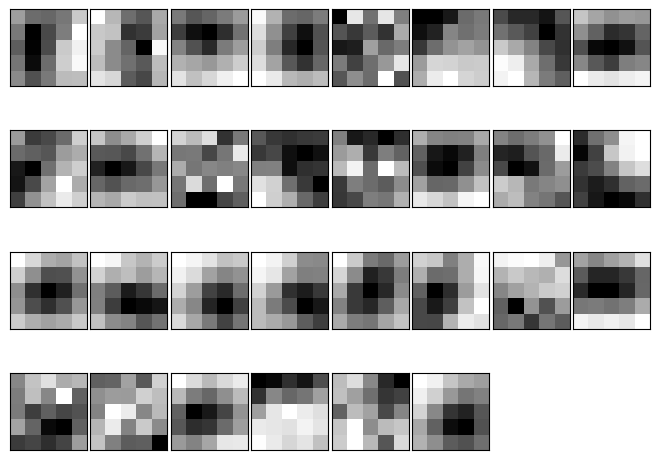

0.0098
train acc, test acc | 0.9129333333333334, 0.9126


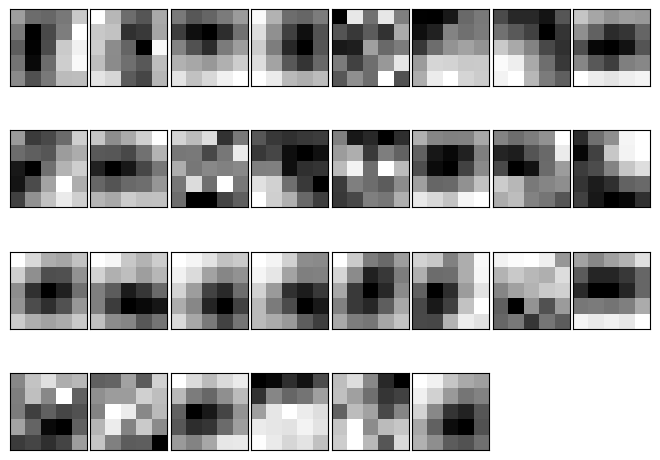

0.0099
train acc, test acc | 0.9440666666666667, 0.9479


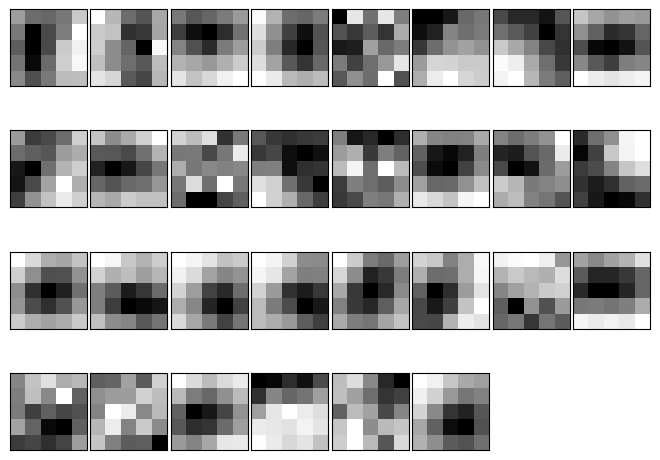

0.01
train acc, test acc | 0.9454166666666667, 0.9497


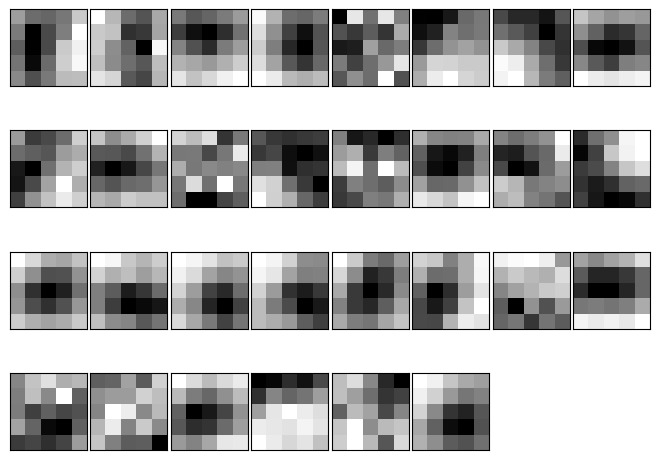

0.0101
train acc, test acc | 0.9457833333333333, 0.9498


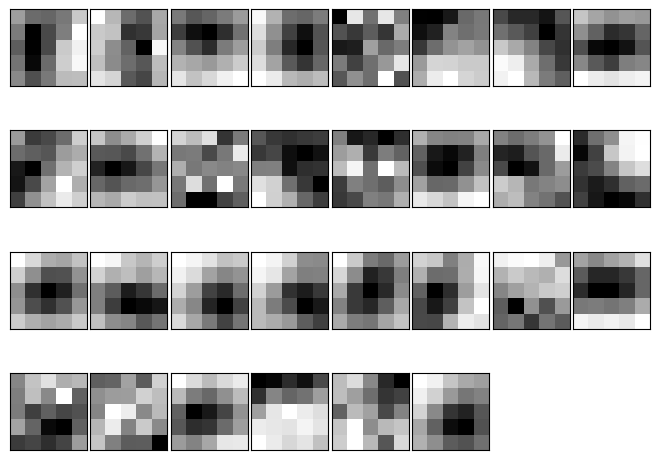

0.0102
train acc, test acc | 0.9464666666666667, 0.9499


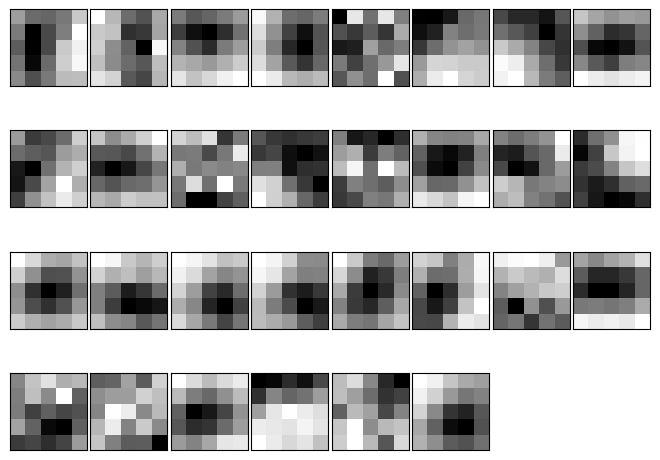

0.0103
train acc, test acc | 0.9466333333333333, 0.9517


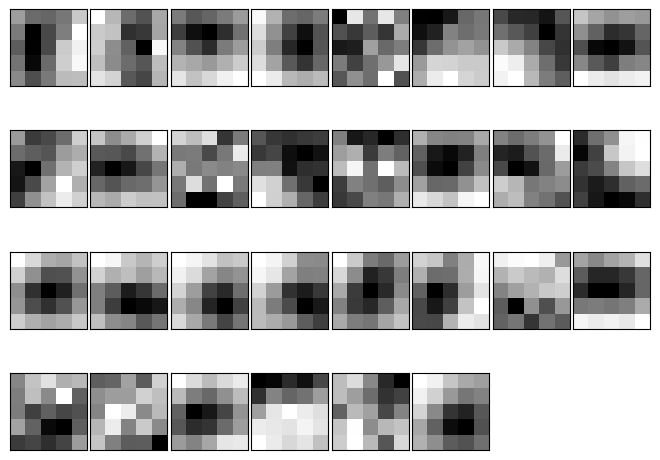

0.0104
train acc, test acc | 0.9455, 0.9489


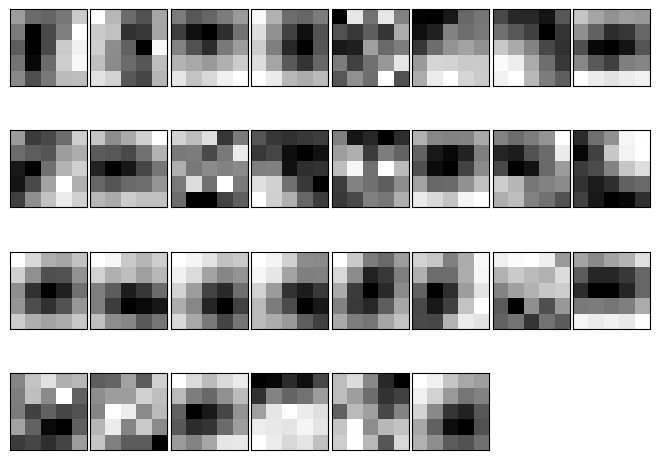

0.0105
train acc, test acc | 0.9474, 0.9514


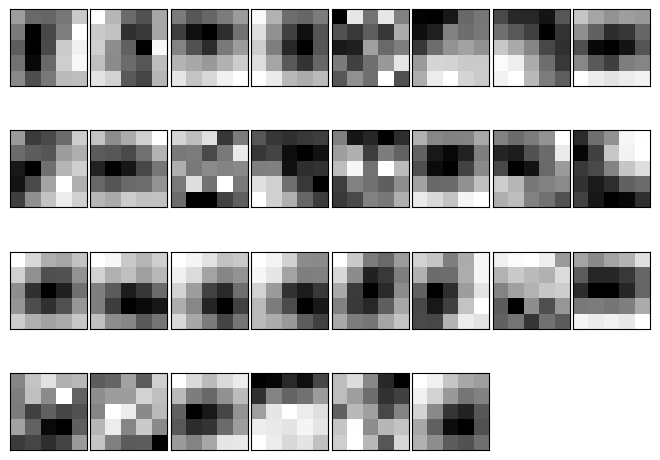

0.0106
train acc, test acc | 0.94735, 0.9502


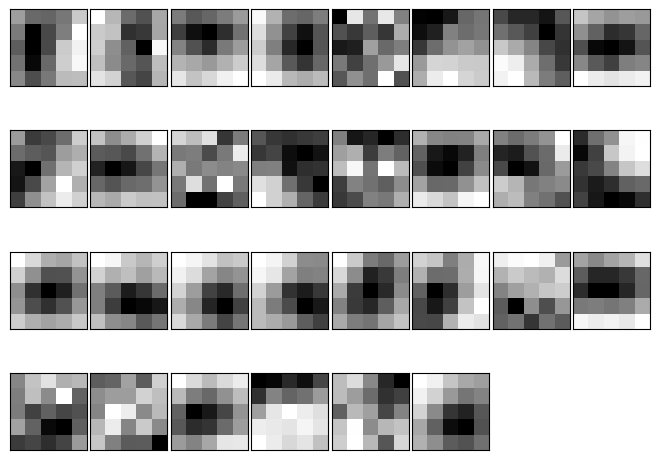

0.0107
train acc, test acc | 0.9478166666666666, 0.9521


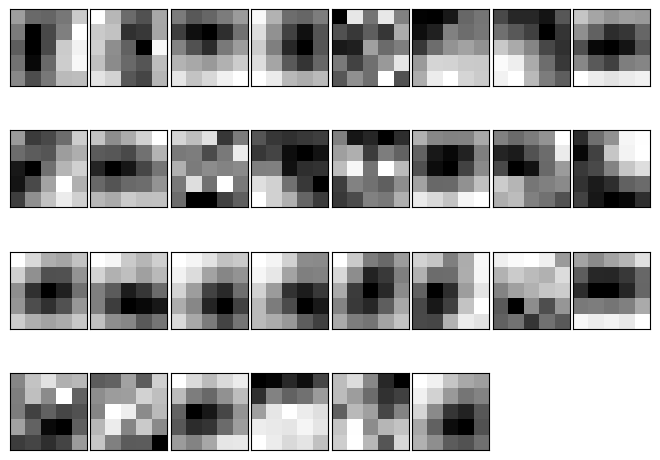

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from ch07.simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=False, one_hot_label=True)

epoch = 1
iters_num = epoch * len(x_train)
train_size = x_train.shape[0]
batch_size = 10000
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2','W3','b3'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f"{i / iters_num}")
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        filter_show(network.params['W1'])